# NLP Project 2024 - Team Baguette - Medical Flashcards
## Members :
Juliette Treyer\
Tanguy Rolland\
Kalisto Willaey\
Théo Moreau

## Data exploration and Clustering

### Data Preparation

We start by importing the dataset using pandas.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import json

df = pd.read_json('/content/drive/MyDrive/medical_meadow_wikidoc_medical_flashcards.json')

df.head(5)

,instruction,input,output
0,Answer this question truthfully,What is the relationship between very low Mg2+...,Very low Mg2+ levels correspond to low PTH lev...
1,Answer this question truthfully,What leads to genitourinary syndrome of menopa...,Low estradiol production leads to genitourinar...
2,Answer this question truthfully,What does low REM sleep latency and experienci...,Low REM sleep latency and experiencing halluci...
3,Answer this question truthfully,What are some possible causes of low PTH and h...,"PTH-independent hypercalcemia, which can be ca..."
4,Answer this question truthfully,How does the level of anti-müllerian hormone r...,The level of anti-müllerian hormone is directl...


### Dataset description

Let's explore our dataset. Displaying the first rows of the dataset using head() allows us to have a first idea of the structure of the dataset. Each row of our dataframe represents a flashcard. The dataframe contains 3 colums: The first column, identical for each row, is the instruction of a flashcard:"Answer this question truthfully". The second column, 'input', contains the question written on a flashcard and the last column, 'output', contains the answer.

Let's check the size of the data set:

In [ ]:
print(f"No. of flashcards: {len(df)}")

No. of flashcards: 33955


For some flashcards, an input and/or and output is missing. We therefore have to delete all of the rows containing empty cells.

In [ ]:
df['input'].replace('', np.nan, inplace=True)
df['output'].replace('', np.nan, inplace=True)
df.dropna(subset=['input'], inplace=True)
df.dropna(subset=['output'], inplace=True)

In [ ]:
print(f"No. of flashcards after cleaning the dataframe: {len(df)}")

No. of flashcards after cleaning the dataframe: 33547


After cleaning the dataframe, the number of remaining flashcards is 33 547.

We are going to create our document collection based on the combination of the input and output of every flashcard.

In [ ]:
documents = df['input']+df['output']
documents[0]

'What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.'

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_json('/kaggle/input/medical-qa/medical_meadow_wikidoc_medical_flashcards.json')
df = df[(df['input'] != "") | (df['output'] != "")]
df = df.drop_duplicates(subset=['input', 'output'])

[Text(0.5, 1.0, 'Answer length distribution')]

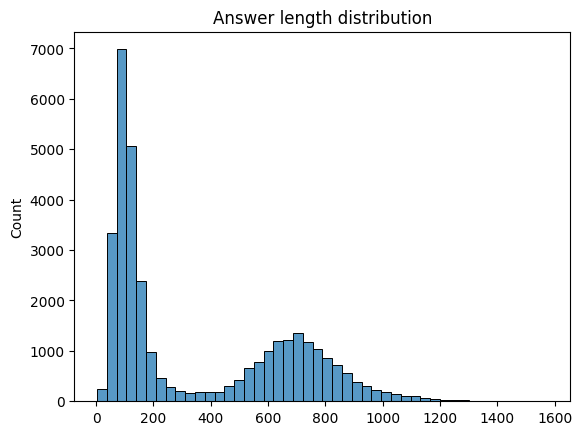

In [ ]:
output_len_distribution = [len(output) for output in df['output'].tolist()]
sns.histplot(data=output_len_distribution).set(title='Answer length distribution')

[Text(0.5, 1.0, 'Question length distribution')]

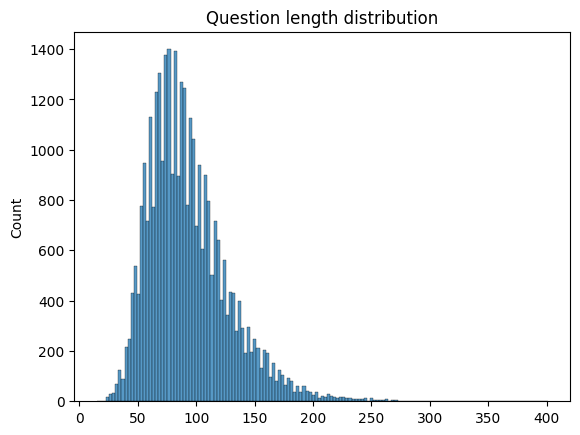

In [ ]:
intput_len_distribution = [len(inp) for inp in df['input'].tolist()]
sns.histplot(data=intput_len_distribution).set(title='Question length distribution')

There is no correlation between question length and answer length.

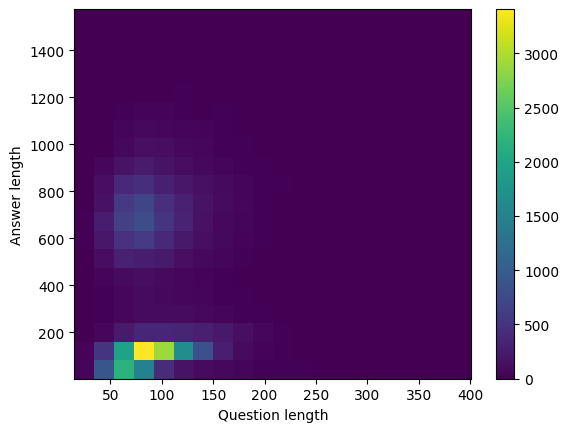

In [ ]:
plt.hist2d(intput_len_distribution, output_len_distribution, bins=20)
plt.xlabel('Question length')
plt.ylabel('Answer length')
plt.colorbar()
plt.show()

### Documents Vectorization

In order to cluster the documents, we use the TfidfVectorizer from Scikit-Learn in order to first convert them into a vector format.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

We can now fit the vectorizer to the data:

In [ ]:
vectorizer.fit(documents)

TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

Let's see the size of the vocabulary:

In [ ]:
vocab = vectorizer.get_feature_names_out()

print(f"Length of vocabulary: {len(vocab)}")

Length of vocabulary: 10952


Now let's vectorize the dataset:

In [ ]:
vector_documents = vectorizer.transform(documents)

As an example, here is the sparse vector for the first document:

In [ ]:
print(vector_documents[0])

  (0, 10311)	0.16185376540407984
  (0, 8591)	0.12445214890947609
  (0, 8436)	0.13257773767597322
  (0, 8117)	0.3346979189266233
  (0, 6278)	0.40584570529003844
  (0, 5879)	0.4393759056387222
  (0, 5739)	0.5609660716960487
  (0, 2292)	0.23240519729934694
  (0, 1428)	0.3197787289848749


Let's sort the terms by their TF-IDF values, and print them out in descending order of TF-IDF values:

In [ ]:
sorted([(vocab[j], vector_documents[0, j]) for j in vector_documents[0].nonzero()[1]], key=lambda x: -x[1])

[('levels', 0.5609660716960487),
 ('low', 0.4393759056387222),
 ('mg2', 0.40584570529003844),
 ('pth', 0.3346979189266233),
 ('ca2', 0.3197787289848749),
 ('correspond', 0.23240519729934694),
 ('turn', 0.16185376540407984),
 ('relationship', 0.13257773767597322),
 ('results', 0.12445214890947609)]

### Data Exploration

Let's calculate the average vocabulary size of a document:

In [ ]:
nonzero_count = vector_documents.count_nonzero()
doc_count = vector_documents.get_shape()[0]

print(f"Average document vocabulary size: {nonzero_count/doc_count}")

Average document vocabulary size: 24.794795361731303


### Searching the collection based on keywords

Given one specific query, we now want to find which document of our collection best matches this query. In order to do that, we compute the similarity between a search query and each of the documents in the collection:

In [ ]:
import numpy as np

query = 'What is a hormone?'

query_vec = vectorizer.transform([query])[0]

index = np.argmax([query_vec.multiply(vector_documents[i]).sum() for i in range(len(documents))])
print(documents[index])

What is the effect of the t(14;18) translocation on the expression of Bcl2 and apoptosis?The t(14;18) translocation results in overexpression of Bcl2, which inhibits apoptosis. Bcl2 is a protein that plays a critical role in regulating cell death by preventing the activation of apoptotic pathways. In normal cells, Bcl2 levels are tightly controlled, but in cells that carry the t(14;18) translocation, the Bcl2 gene is abnormally activated, leading to overexpression of the protein. This overexpression of Bcl2 can promote cell survival and contribute to the development of certain types of cancer, such as follicular lymphoma. Understanding the role of Bcl2 in cancer has led to the development of targeted therapies that aim to inhibit its activity and promote apoptosis in cancer cells.


#Clustering
Let's start applying clustering to our vectorised documents:

## Clustering with k-means

In [ ]:
from sklearn.cluster import KMeans

k = 25

kmeans = KMeans(n_clusters=k, max_iter=100, n_init=2, verbose=True, random_state=2307)
kmeans.fit(vector_documents)

Initialization complete
Iteration 0, inertia 61310.399469744974.
Iteration 1, inertia 32578.90045754616.
Iteration 2, inertia 32398.048358604457.
Iteration 3, inertia 32290.091036221835.
Iteration 4, inertia 32228.289466754264.
Iteration 5, inertia 32186.429708803604.
Iteration 6, inertia 32160.423429148188.
Iteration 7, inertia 32143.703147538523.
Iteration 8, inertia 32131.886761129223.
Iteration 9, inertia 32124.527210301894.
Iteration 10, inertia 32120.11373314004.
Iteration 11, inertia 32115.97533712249.
Iteration 12, inertia 32109.2636283366.
Iteration 13, inertia 32102.94536803716.
Iteration 14, inertia 32097.35922765031.
Iteration 15, inertia 32095.924420219635.
Iteration 16, inertia 32095.01183520221.
Iteration 17, inertia 32094.188041757596.
Iteration 18, inertia 32093.51582384708.
Iteration 19, inertia 32092.818453954053.
Iteration 20, inertia 32092.32123120124.
Iteration 21, inertia 32092.14414464825.
Iteration 22, inertia 32091.948040057403.
Iteration 23, inertia 32091.671

KMeans(max_iter=100, n_clusters=25, n_init=2, random_state=2307, verbose=True)

### Clustering Evaluation

#### Investigating the clusters
The important terms for each cluster can be determined by inspecting the centroid vector for the cluster.
TO get a more precise idea, we can have a look at the terms with high weights in the centroid of the first cluster:

In [ ]:
# Get the centroid for the first cluster
centroid = kmeans.cluster_centers_[0]

# Sort terms according to their weights
# (argsort goes from lowest to highest, we reverse the order through slicing)
sorted_terms = centroid.argsort()[::-1]

# Print out the top 10 terms for the cluster
[vocab[j] for j in sorted_terms[:20]]

['deficiency',
 'vitamin',
 'iron',
 'anemia',
 'b12',
 'folate',
 'hydroxylase',
 'blood',
 'cause',
 'levels',
 'body',
 'lead',
 'condition',
 'important',
 'symptoms',
 'g6pd',
 'associated',
 'enzyme',
 'sideroblastic',
 'diet']

We can now also find the document in the collection that best illustrates this cluster:

In [ ]:
index = np.argmax([np.dot(centroid,vec) for vec in vector_documents.toarray()])

print(documents[index])

What is one clinical feature of Cushing syndrome that involves abdominal striae, which is a result of impaired collagen synthesis, allowing blood vessels to rupture easily?One clinical feature of Cushing syndrome involves abdominal striae, which is a result of impaired collagen synthesis, allowing blood vessels to rupture easily.


Let's see the number of documents assigned to each cluster:

In [ ]:
for j in range(k):
    print("No of documents assigned to cluster", j,":",sum(kmeans.labels_ == j))

No of documents assigned to cluster 0 : 620
No of documents assigned to cluster 1 : 3628
No of documents assigned to cluster 2 : 544
No of documents assigned to cluster 3 : 1326
No of documents assigned to cluster 4 : 2864
No of documents assigned to cluster 5 : 1051
No of documents assigned to cluster 6 : 1214
No of documents assigned to cluster 7 : 1794
No of documents assigned to cluster 8 : 642
No of documents assigned to cluster 9 : 501
No of documents assigned to cluster 10 : 765
No of documents assigned to cluster 11 : 418
No of documents assigned to cluster 12 : 347
No of documents assigned to cluster 13 : 10101
No of documents assigned to cluster 14 : 293
No of documents assigned to cluster 15 : 749
No of documents assigned to cluster 16 : 482
No of documents assigned to cluster 17 : 1220
No of documents assigned to cluster 18 : 280
No of documents assigned to cluster 19 : 1042
No of documents assigned to cluster 20 : 1248
No of documents assigned to cluster 21 : 780
No of doc

Let's get the top terms for all the clusters:

In [ ]:
print("Top terms per cluster:")
vocab = vectorizer.get_feature_names_out()

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:10]]}")

Top terms per cluster:
Cluster 0:	['deficiency', 'vitamin', 'iron', 'anemia', 'b12', 'folate', 'hydroxylase', 'blood', 'cause', 'levels']
Cluster 1:	['common', 'typically', 'cause', 'pregnancy', 'tumor', 'commonly', 'infection', 'age', 'tumors', 'fetal']
Cluster 2:	['virus', 'hepatitis', 'infection', 'viruses', 'viral', 'herpes', 'hsv', 'epstein', 'barr', 'vaccine']
Cluster 3:	['syndrome', 'associated', 'symptoms', 'condition', 'disorder', 'characterized', 'cause', 'caused', 'nephrotic', 'genetic']
Cluster 4:	['symptoms', 'pain', 'condition', 'cause', 'treatment', 'include', 'medical', 'fever', 'infection', 'typically']
Cluster 5:	['heart', 'blood', 'pressure', 'cardiac', 'failure', 'pulmonary', 'flow', 'hypertension', 'right', 'left']
Cluster 6:	['cells', 'blood', 'red', 'immune', 'type', 'cell', 'anemia', 'response', 'role', 'body']
Cluster 7:	['used', 'treat', 'effects', 'medication', 'treatment', 'patients', 'commonly', 'medications', 'drug', 'potential']
Cluster 8:	['cancer', 'bre

It seems like each of the clusters contains relatively consistent terms.

#### Intrinsic Evaluation

Let's import some metrics to evaluate our clustering.

In [ ]:
from sklearn import metrics

print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(kmeans.inertia_))
print("Silhouette coefficient:", str(metrics.silhouette_score(vector_documents, kmeans.labels_)))

Intrinsic evaluation measures:
Within-cluster sum-of-squares: 32081.383937378494
Silhouette coefficient: 0.0087535274830044


#### Selecting a value for k using minibatch k-means clustering

We now want to determine which number of clusters k gives the best clustering result. In order to do this, we will plot the within-cluster sum of squares as a funtion of the number of clusters k and hope to find a point on the graph where performance suddenly stops getting a lot better.

In [ ]:
from sklearn.cluster import MiniBatchKMeans
performance = [MiniBatchKMeans(n_clusters=k, batch_size=500, random_state=2307).fit(vector_documents).inertia_ for k in range(1,50)]
performance

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[33262.89807326159,
 33180.36924084705,
 33097.54680230605,
 33041.82951702435,
 32976.35344412617,
 32974.891509561414,
 32896.66661020817,
 32830.949217156536,
 32787.03532431739,
 32786.61928624503,
 32736.914436147264,
 32696.9082215291,
 32648.66750302969,
 32636.40108843265,
 32568.35279653848,
 32564.044353038007,
 32553.372903551324,
 32463.845476811195,
 32513.49064811212,
 32463.280498843407,
 32398.09814078973,
 32382.607393158556,
 32377.044385924568,
 32323.458371442062,
 32362.73709059224,
 32334.072394289797,
 32271.702779394353,
 32320.32424979887,
 32279.555302118264,
 32256.090007736944,
 32318.2137359608,
 32253.708134458117,
 32238.369503901617,
 32218.24162040394,
 32189.497592257892,
 32107.545292050356,
 32053.86388839435,
 32185.028227063438,
 32153.938281189046,
 32262.35602918805,
 32020.40137556829,
 32187.76334715107,
 32087.7630955471,
 31943.7204935798,
 32099.057599584878,
 32130.528456193562,
 31956.523365903093,
 32295.918178255677,
 32176.12958320453]

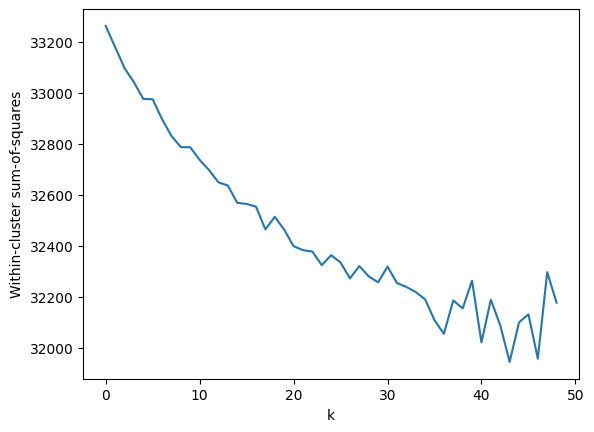

In [ ]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(performance)
plt.ylabel('Within-cluster sum-of-squares')
plt.xlabel('k')
plt.show()

It seems like the clustering becomes better from a number of k=30 clusters.

### Visualisation

In order to visualise the data, we'll try to transform the high dimensional data into low dimensional data (3 dimensions) using the linear dimensionality reduction technique called Singular Value Decomposition.

Let's transform the vector_documents to be 3 dimensional.

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(3)
reduced_data = svd.fit_transform(vector_documents)

[x,y,z] = np.transpose(reduced_data)
[x,y,z]

[array([0.08833246, 0.0477731 , 0.03517993, ..., 0.00518545, 0.05846911,
        0.03387706]),
 array([ 0.01826695, -0.0069272 , -0.01420079, ..., -0.00026269,
         0.02356732, -0.0018589 ]),
 array([ 0.17539779,  0.01342471,  0.01230694, ...,  0.00085165,
        -0.04931183, -0.01679316])]

Now that we have the data in the right form, let's plot it with colours determined by the clusters found by the original k-Means algorithm:

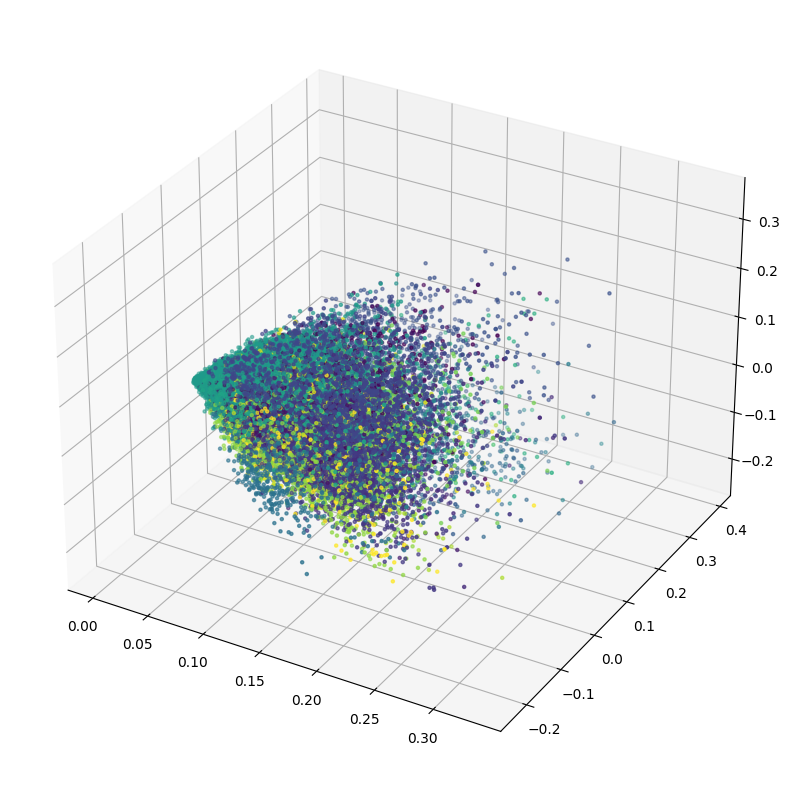

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=kmeans.labels_, marker='.');

It doesn't look like clear distinct clusters are formed using Singular Value Decomposition. Let's try another technique: Topic modelling using LDA.

### Topic modelling: LDA

First, let's split the data into a training and a test set.

In [ ]:
from sklearn.model_selection import train_test_split

documents_train, documents_test = train_test_split(documents, test_size=0.4)

Let's vectorize our documents from the training set:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english',min_df=5,max_df=.5)
vector_documents_train = vectorizer.fit_transform(documents_train)

Let's have a look at the size of our vocabulary:

In [ ]:
vocab = vectorizer.get_feature_names_out()
len(vocab)

8575

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=30, verbose=1, learning_method='online', max_iter=30)
lda.fit(vector_documents_train)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


LatentDirichletAllocation(learning_method='online', max_iter=30,
                          n_components=30, verbose=1)

We can now have a look at the topics found by printing out the 10 most important terms for each topic:


In [ ]:
import numpy as np

for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    concatenated_terms = '[' + ', '.join(vocab[i] for i in sorted_terms[:10]) + ']'
    print (f'Topic {i + 1}:\t', concatenated_terms)

Topic 1:	 [tract, small, following, associated, bowel, intestine, disease, colon, gastrointestinal, pneumonia]
Topic 2:	 [primary, layer, defect, bile, stain, hodgkin, syphilis, genital, biliary, enter]
Topic 3:	 [considered, non, line, anemia, myocardial, stress, blockers, meningitis, infarction, second]
Topic 4:	 [dna, viral, gland, plays, bladder, rna, hormone, hormones, molecule, urinary]
Topic 5:	 [nerve, pancreatic, responsible, enzymes, neurons, muscles, cranial, diabetic, nucleus, pancreas]
Topic 6:	 [disease, chronic, patients, cell, type, characterized, cells, stage, typically, secondary]
Topic 7:	 [test, used, tests, diagnostic, imaging, injury, step, testing, ultrasound, diagnose]
Topic 8:	 [cancer, carcinoma, skin, breast, cervical, tissue, type, screening, mass, biopsy]
Topic 9:	 [bacteria, bacterial, infections, positive, negative, antibiotics, protein, used, gram, antibiotic]
Topic 10:	 [lymphoma, vaccine, terms, pth, murmur, cns, adult, diffuse, complete, testosterone]

The terms appearing in each of the clusters seem to be rather consistent.

Let's visualise the prevalence of the words in each topics:

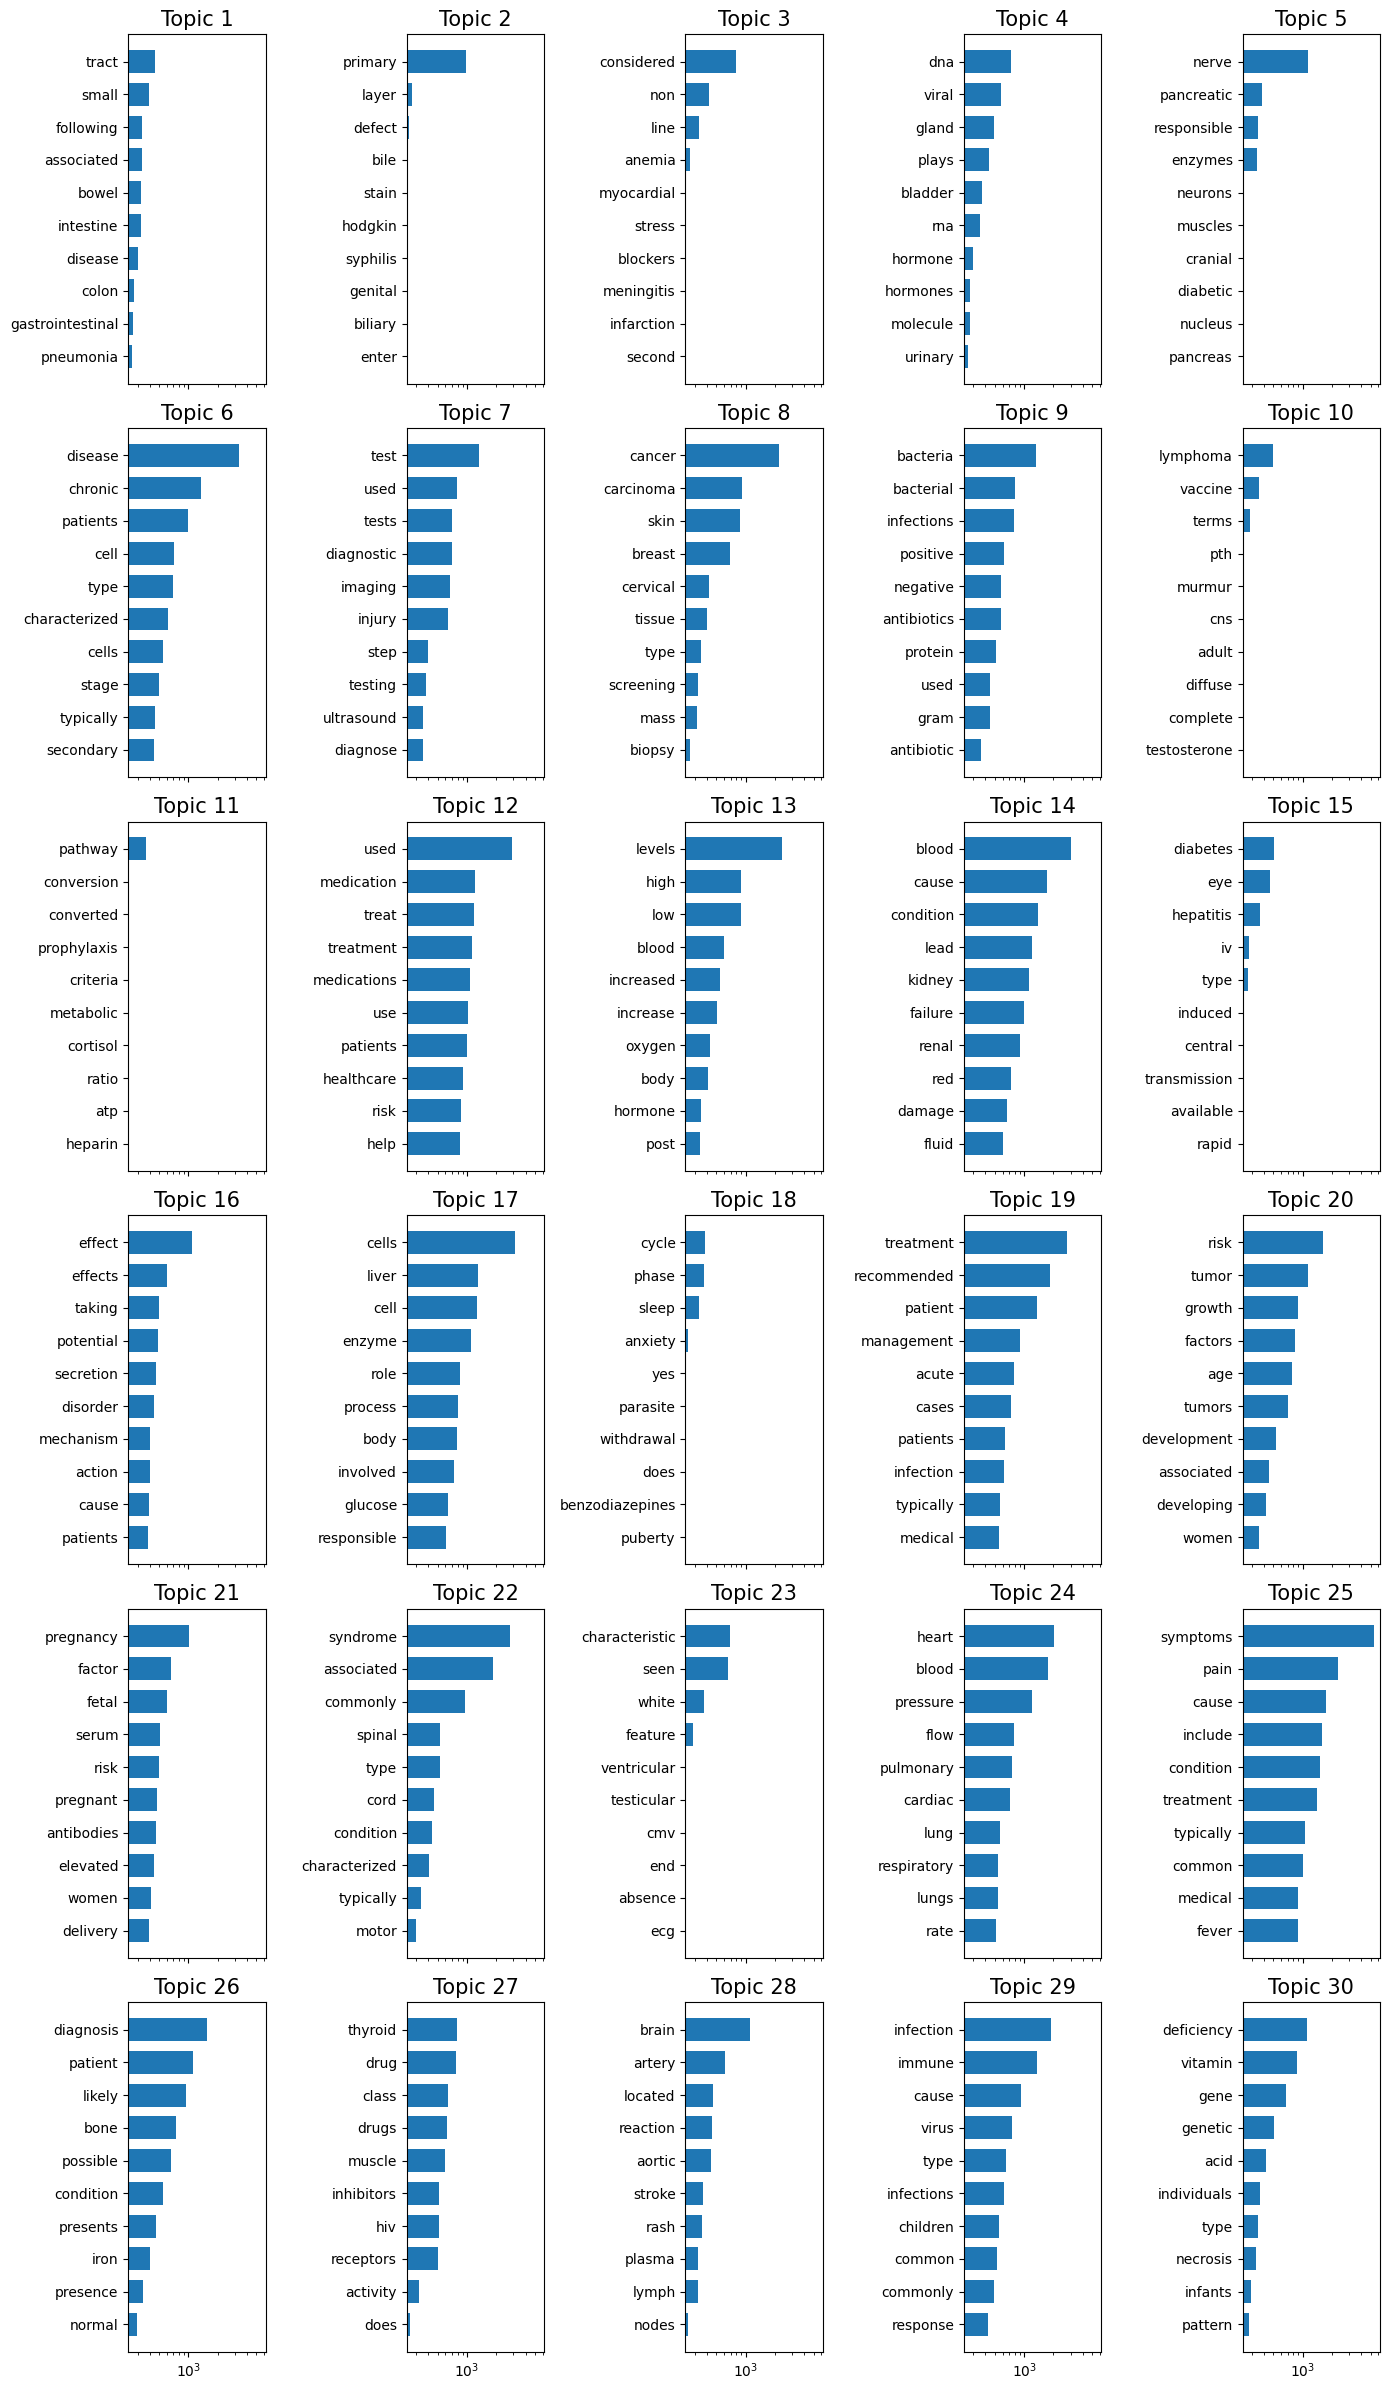

In [ ]:
num_words = 10
cols = 5
rows = int(len(lda.components_)/5)

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda.components_):
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [vocab[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[topic_idx]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx +1}',fontdict={'fontsize': 15})
    ax.invert_yaxis()
    ax.set_xscale('log')

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.tight_layout()
plt.show()

### Visualising Topic Representations of Documents with t-SNE

Let's use perplexity in order to measure the performance of the model:

In [ ]:
vector_documents_test = vectorizer.transform(documents_test)
lda.perplexity(vector_documents_test)

2002.0711833678133

We'll run t-SNE on the test data set that wasn't used to estimate the LDA model, and create an 3-dimensional embedding from the high-dimensional data:

In [ ]:
from sklearn.manifold import TSNE

tsne_embedding = TSNE(n_components=3).fit_transform(lda.transform(vector_documents_test))
tsne_embedding.shape

(13419, 3)

Now we convert the data to the (x,y,z) format needed for plotting:

In [ ]:
[x, y, z] = np.transpose(tsne_embedding)

Finally, we can assign each document to its most frequent topic and colour based on the topic:

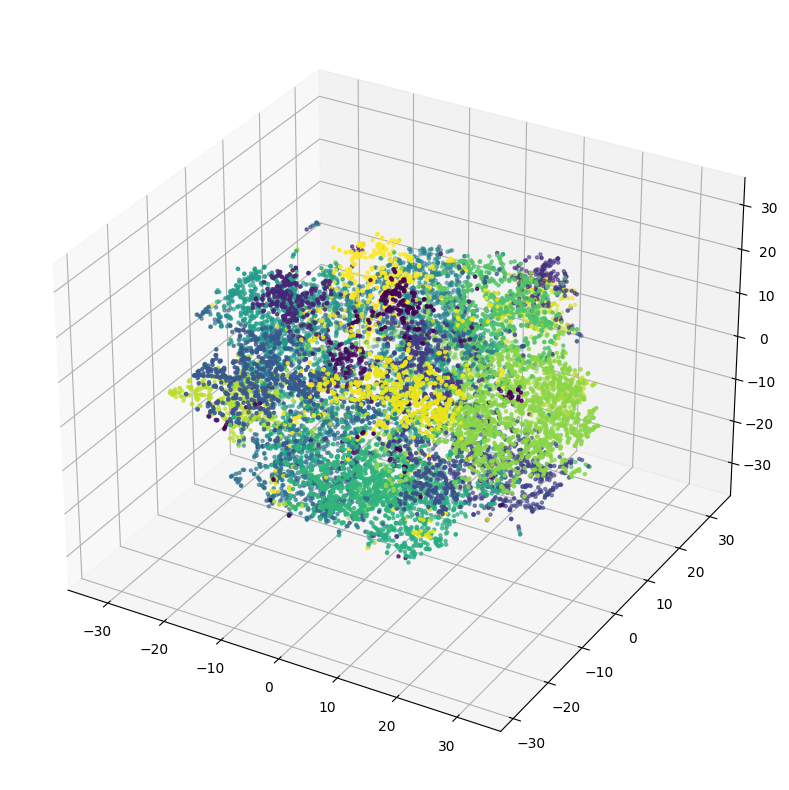

In [ ]:
freq_topic = [topic_vec.argsort()[-1] for topic_vec in lda.transform(vector_documents_test)]

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=freq_topic, marker='.');

This time, clearly distinct clusters seem to have been created. Using t-SNE and LDA is a good way to perfrom clustering on this dataset.

# Training a Word2Vec

In [ ]:
import pandas as pd
import random
import re
from pandas.core.common import flatten
from gensim.models.word2vec import Word2Vec

## Import dataset

In [ ]:
df = pd.read_json('medical_meadow_wikidoc_medical_flashcards.json')

df.head(5)

,instruction,input,output
0,Answer this question truthfully,What is the relationship between very low Mg2+...,Very low Mg2+ levels correspond to low PTH lev...
1,Answer this question truthfully,What leads to genitourinary syndrome of menopa...,Low estradiol production leads to genitourinar...
2,Answer this question truthfully,What does low REM sleep latency and experienci...,Low REM sleep latency and experiencing halluci...
3,Answer this question truthfully,What are some possible causes of low PTH and h...,"PTH-independent hypercalcemia, which can be ca..."
4,Answer this question truthfully,How does the level of anti-müllerian hormone r...,The level of anti-müllerian hormone is directl...


## Pre-processing of the data

In [ ]:
# We choosed to keep both input and output in order to train the Word2Vec but keeping
# only one column would also be an option
dataset = list(df['input']) + list(df['output'])

# set up seed for reproducibility
random.seed(42)

# shuffle the dataset randomly
random.shuffle(dataset)

# Split the list into training (70%) and testing (30%) parts
split_index = int(0.7 * len(dataset))
dataset_train = dataset[:split_index]
dataset_test = dataset[split_index:]

In [ ]:
dataset_test

['Trypsin results in increased cleavage of trypsinogen to trypsin.',
 'The medullary pyramids (papillae) of the kidney empty into major and minor calyces.',
 'Micelles play a crucial role in lipid digestion and absorption in the small intestine by bringing the products of lipid digestion into contact with the intestinal brush border. This is where the lipid products diffuse across the luminal membrane and enter the enterocytes, which are the cells that line the small intestine. Without micelles, the lipid products would not be able to come into contact with the brush border and would not be efficiently absorbed by the body.',
 'Class IA antiarrhythmics are used to treat both supraventricular and ventricular arrhythmias.',
 'Which renal pathology is commonly associated with sickle cell anemia?',
 "The likely diagnosis for the patient's condition is viral esophagitis, which can be caused by viruses such as herpes simplex virus or cytomegalovirus, or Candidal esophagitis, which is caused 

## Separate data into individual sentences

In [ ]:
# remove newline characters
docs = [re.sub('\n', ' ', doc) for doc in dataset_train]
# remove email addresses
docs = [re.sub('[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', doc) for doc in docs]
# split sentences
sentences = [re.split('[?!.]\s', doc) for doc in docs]
sentences[:3]

[[''],
 ['Normal aging typically causes a decrease in respiratory muscle strength.'],
 ['Sturge-Weber syndrome is a rare neurological disorder that is characterized by abnormal blood vessels on the surface of the brain and skin',
  'It can cause symptoms such as seizures, intellectual disability, and glaucoma',
  'The condition is caused by an activating mutation in one copy of the GNAQ gene, which leads to the abnormal development of blood vessels.']]

## flatten the structure into one big array of sentences

In [ ]:
sentences = list(flatten(sentences))
sentences[:20]

['',
 'Normal aging typically causes a decrease in respiratory muscle strength.',
 'Sturge-Weber syndrome is a rare neurological disorder that is characterized by abnormal blood vessels on the surface of the brain and skin',
 'It can cause symptoms such as seizures, intellectual disability, and glaucoma',
 'The condition is caused by an activating mutation in one copy of the GNAQ gene, which leads to the abnormal development of blood vessels.',
 'A vasectomy is a surgical technique used as a male contraceptive method',
 'It involves the transection of the vas deferens, which is the tube that carries sperm from the epididymis to the urethra',
 'By cutting or blocking the vas deferens, a vasectomy prevents the transport of new sperm from the epididymis, thus making the man sterile',
 "The procedure is usually performed under local anesthesia and can be done in a doctor's office or clinic",
 'Vasectomy is considered a permanent form of birth control, but it is possible to reverse the proc

## Cleaning of the data:
- remove non-letter characters from each sentence
- lowercase
- tokenize the sentences based on whitespace
- remove any sentence with length less than 2

In [ ]:
tokenized_sentences = [re.sub('\W', ' ', sentence).lower().split() for sentence in sentences]
# remove sentences that are only 1 word long
tokenized_sentences = [sentence for sentence in tokenized_sentences if len(sentence) > 1]

for sentence in tokenized_sentences[:10]:
    print(sentence)

['normal', 'aging', 'typically', 'causes', 'a', 'decrease', 'in', 'respiratory', 'muscle', 'strength']
['sturge', 'weber', 'syndrome', 'is', 'a', 'rare', 'neurological', 'disorder', 'that', 'is', 'characterized', 'by', 'abnormal', 'blood', 'vessels', 'on', 'the', 'surface', 'of', 'the', 'brain', 'and', 'skin']
['it', 'can', 'cause', 'symptoms', 'such', 'as', 'seizures', 'intellectual', 'disability', 'and', 'glaucoma']
['the', 'condition', 'is', 'caused', 'by', 'an', 'activating', 'mutation', 'in', 'one', 'copy', 'of', 'the', 'gnaq', 'gene', 'which', 'leads', 'to', 'the', 'abnormal', 'development', 'of', 'blood', 'vessels']
['a', 'vasectomy', 'is', 'a', 'surgical', 'technique', 'used', 'as', 'a', 'male', 'contraceptive', 'method']
['it', 'involves', 'the', 'transection', 'of', 'the', 'vas', 'deferens', 'which', 'is', 'the', 'tube', 'that', 'carries', 'sperm', 'from', 'the', 'epididymis', 'to', 'the', 'urethra']
['by', 'cutting', 'or', 'blocking', 'the', 'vas', 'deferens', 'a', 'vasectom

## Training Word2Vec with the following parameters:
- embedding size = 30
- minimum count for any vocabulary term = 5
- size of the context window = 10

In [ ]:
model = Word2Vec(tokenized_sentences, vector_size=30, min_count=5, window=10)

### size of the model

In [ ]:
len(model.wv)

11659

## Investigating embeddings

- print out one of the vectors

In [ ]:
term = 'syndrome'
model.wv[term]

array([-3.2498856 ,  0.36848438,  3.5361726 ,  3.3196156 , -2.581625  ,
       -3.4670458 ,  6.369612  ,  3.3265705 , -0.43847513, -3.9936144 ,
        2.6940022 , -4.1363573 ,  4.584766  ,  6.807432  , -0.3715899 ,
        1.0590575 , -1.3128629 , -3.7359717 ,  0.58928096, -1.3134782 ,
       -5.737021  ,  1.6400664 , -2.3478017 , -2.0477886 , -1.3481982 ,
       -2.2522922 ,  5.6261425 ,  3.3828032 ,  2.273651  ,  1.9437759 ],
      dtype=float32)

- print the closest neighbouring of some terms

In [ ]:
term = 'intellectual'
#term = 'sturge'
#term ='hypertrophy'

model.wv.most_similar(term)

[('disability', 0.973355770111084),
 ('delays', 0.9204159379005432),
 ('disabilities', 0.8541625738143921),
 ('ataxia', 0.8347007036209106),
 ('neurological', 0.8323556780815125),
 ('developmental', 0.819753110408783),
 ('deficits', 0.8144023418426514),
 ('impairment', 0.7961452007293701),
 ('confusion', 0.7875177264213562),
 ('hypotonia', 0.7844393253326416)]

# Retrieval based chatbot

## Librairies

In [ ]:
pip install -q python-terrier

In [ ]:
import pandas as pd
import pyterrier as pt

## Import dataset

In [ ]:
df = pd.read_json('medical_meadow_wikidoc_medical_flashcards.json')

df.head(5)

,instruction,input,output
0,Answer this question truthfully,What is the relationship between very low Mg2+...,Very low Mg2+ levels correspond to low PTH lev...
1,Answer this question truthfully,What leads to genitourinary syndrome of menopa...,Low estradiol production leads to genitourinar...
2,Answer this question truthfully,What does low REM sleep latency and experienci...,Low REM sleep latency and experiencing halluci...
3,Answer this question truthfully,What are some possible causes of low PTH and h...,"PTH-independent hypercalcemia, which can be ca..."
4,Answer this question truthfully,How does the level of anti-müllerian hormone r...,The level of anti-müllerian hormone is directl...


In [ ]:
df.replace('', pd.NA, inplace = True)
df.dropna(inplace = True)
df.reset_index(drop=True, inplace=True)

df.shape

(33547, 3)

In [ ]:
# Create a list of values for the new column 'docno'
docno_values = ['d' + str(i) for i in range(1, len(df) + 1)]

# Add the new column 'docno' to the DataFrame
df['docno'] = docno_values

df.head(5)

,instruction,input,output,docno
0,Answer this question truthfully,What is the relationship between very low Mg2+...,Very low Mg2+ levels correspond to low PTH lev...,d1
1,Answer this question truthfully,What leads to genitourinary syndrome of menopa...,Low estradiol production leads to genitourinar...,d2
2,Answer this question truthfully,What does low REM sleep latency and experienci...,Low REM sleep latency and experiencing halluci...,d3
3,Answer this question truthfully,What are some possible causes of low PTH and h...,"PTH-independent hypercalcemia, which can be ca...",d4
4,Answer this question truthfully,How does the level of anti-müllerian hormone r...,The level of anti-müllerian hormone is directl...,d5


In [ ]:
df['input'][0]

'What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?'

In [ ]:
import random
random.seed(2)

# Generate n_test random numbers between 1 and 100
n_test = 100
random_numbers = [random.randint(1, df.shape[0]) for _ in range(n_test)]
print(random_numbers)

[3707, 6003, 5563, 23663, 11082, 20195, 16488, 13908, 2342, 10380, 28225, 25791, 33363, 24384, 29154, 32904, 17580, 2355, 1799, 23857, 30468, 20871, 24905, 27762, 10780, 11629, 15475, 15113, 1564, 11582, 21309, 11377, 8959, 33435, 33439, 23573, 11918, 29206, 27176, 23872, 23186, 23717, 29214, 10564, 26206, 30239, 16378, 32114, 18292, 32642, 32824, 23195, 29799, 30213, 22989, 29921, 31891, 14537, 21278, 10884, 17573, 31442, 20288, 19877, 33047, 33251, 26652, 20438, 13620, 32041, 24026, 4940, 22378, 552, 12544, 6958, 3851, 3206, 17898, 14852, 6965, 8946, 17423, 16046, 13794, 3958, 27717, 2089, 3723, 23748, 23608, 11265, 16352, 1537, 5434, 7552, 4422, 1661, 2679, 1386]


In [ ]:
df_train = df.drop(random_numbers, axis=0)
df_test = df.iloc[random_numbers,]

## Initialising PyTerrier

In [ ]:
if not pt.started():
    pt.init()

## Indexing

In [ ]:
df = df_train

indexer = pt.DFIndexer("./index", overwrite = True)
index_ref = indexer.index(df["input"], df['output'], df["docno"])
index_ref.toString()

'./index/data.properties'

## Querying the index

In [ ]:
index = pt.IndexFactory.of(index_ref)
print(index.getCollectionStatistics().toString())

Number of documents: 33447
Number of terms: 11344
Number of postings: 247079
Number of fields: 0
Number of tokens: 253454
Field names: []
Positions:   false



## Define retriever

In [ ]:
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

In [ ]:
query = 'what is the medical term for inflammation of the appendix'

bm25.search(query).head(10)

,qid,docid,docno,rank,score,query
0,1,25356,d25430,0,15.689068,what is the medical term for inflammation of t...
1,1,2716,d2727,1,15.609720,what is the medical term for inflammation of t...
2,1,32551,d32645,2,15.609720,what is the medical term for inflammation of t...
3,1,2139,d2147,3,14.879578,what is the medical term for inflammation of t...
4,1,21642,d21702,4,14.688557,what is the medical term for inflammation of t...
5,1,12159,d12195,5,14.056838,what is the medical term for inflammation of t...
6,1,3849,d3864,6,13.870056,what is the medical term for inflammation of t...
7,1,24047,d24119,7,13.870056,what is the medical term for inflammation of t...
8,1,20476,d20533,8,13.273539,what is the medical term for inflammation of t...
9,1,21643,d21703,9,13.137961,what is the medical term for inflammation of t...


In [ ]:
docno = bm25.search(query)['docno'][0]
i = df[df['docno'] == docno].index
print("input: ", df.iloc[i[0]]['input'])
print("output: ", df.iloc[i[0]]['output'])

input:  What type of precocious puberty is idiopathic precocious puberty?
output:  Idiopathic precocious puberty is a form of central precocious puberty.


### Fonction to clean the query

In [ ]:
import re

# Function to clean the query
def clean_query(query):
    # Replace problematic characters with spaces and trim whitespace
    query = re.sub(r'[^\w\s]', ' ', query)
    query = query.replace("\n", " ").replace("\r", " ").strip()
    return query

## Generate the outputs

In [ ]:
bm25_outputs = []

for i in range(df_test.shape[0]):
  query = clean_query( df_test.iloc[i]['input'] )

  docno = bm25.search(query)['docno'][0]
  j = df[df['docno'] == docno].index

  bm25_outputs.append( df.iloc[j[0]]['output'] )

## Evaluation

### Cosine Similarity

In [ ]:
!pip install -q sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 38.6 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer

sentence_embedding_model = SentenceTransformer('sentence-transformers/sentence-t5-base')

# 1 candidate correspond to only 1 reference
def sentence_similarity(references, candidates):
    references_embedding = sentence_embedding_model.encode(references)
    candidates_embedding = sentence_embedding_model.encode(candidates)
    cosine_similarity = []
    for i in range(len(references_embedding)):
        cosine_similarity.append(references_embedding[i].dot(candidates_embedding[i])) # Model normalizes output embedding vector

    return cosine_similarity

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/219M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

rust_model.ot:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [ ]:
ft_similarity = sentence_similarity(list(df_test['output']), bm25_outputs)

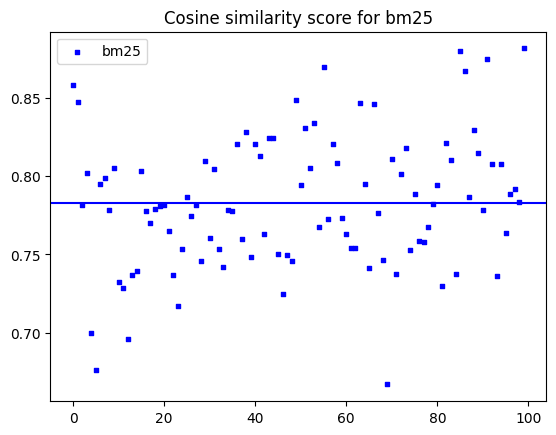

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = range(n_test)
y1 = ft_similarity
ft_mean = np.mean(y1)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, y1, s=10, c='b', marker="s", label='bm25')
ax1.axhline(ft_mean,c='b')
ax1.title.set_text('Cosine similarity score for bm25')
plt.legend(loc='upper left')
plt.show()

In [ ]:
ft_mean = np.mean(ft_similarity)
print(f'The Cosine similarity score for bm25 is: {ft_mean}')

The Cosine similarity score for bm25 is: 0.7831006050109863


### Bert Score

In [ ]:
references = list(df_test['output'])
qa_answers = bm25_outputs

In [ ]:
pip install -q bert_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.4 MB/s eta 0:00:00


In [ ]:
pip install -q evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00


In [ ]:
import bert_score
from evaluate import load
from transformers import AutoTokenizer
from transformers import AutoModel

In [ ]:
BERT_MODEL = "microsoft/deberta-large-mnli"

In [ ]:
deberta_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
deberta_model = AutoModel.from_pretrained(BERT_MODEL)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

In [ ]:
bertscore = load("bertscore")

bertscore_test = bertscore.compute(predictions=qa_answers, references=references, model_type=BERT_MODEL)
print(bertscore_test['f1'])

[0.597596287727356, 0.5203613638877869, 0.4923609495162964, 0.5368713736534119, 0.45038509368896484, 0.37041211128234863, 0.5522645711898804, 0.5484187602996826, 0.48890435695648193, 0.5131410956382751, 0.5040199160575867, 0.4298092722892761, 0.48125773668289185, 0.4482286274433136, 0.488615483045578, 0.46297669410705566, 0.5331684947013855, 0.4568496346473694, 0.5215728878974915, 0.44539517164230347, 0.45734336972236633, 0.5015162229537964, 0.44284936785697937, 0.42822179198265076, 0.4763830006122589, 0.5049276947975159, 0.49737995862960815, 0.5971555113792419, 0.4021828770637512, 0.480228066444397, 0.48253822326660156, 0.5051073431968689, 0.46074163913726807, 0.49426722526550293, 0.4398250877857208, 0.5509763360023499, 0.5385464429855347, 0.5177188515663147, 0.48010411858558655, 0.46103477478027344, 0.4960416555404663, 0.48296546936035156, 0.44106432795524597, 0.5784885883331299, 0.5073186159133911, 0.46131768822669983, 0.3995305895805359, 0.4901495575904846, 0.46655482053756714, 0.4

In [ ]:
import statistics
mean_bertscore_sentence_transformers=statistics.mean(bertscore_test['f1'])
print(f'The Bert score for bm25 is: {mean_bertscore_sentence_transformers}')

The Bert score for bm25 is: 0.498742039501667


#Question Answering using Sentence Transformers

## Prepare environment

In [ ]:
!pip install -U sentence-transformers
!pip install datasets
!pip install hnswlib

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

## Question answering pipeline

In this part, the goal is to create a question answering pipeline. For a given question, the model returns the best answer found in the dataset. Moreover, as we want to compute some metrics in order to evaluate our model, we will leave a few flashcards out of the dataset used to train our model. We will then compare the answer given by our model to the actual answer written on the flashcard when asking the question written on each of those left-out flashcards.

Let's start by loading a sentence embedding model and a cross encoder model.

In [ ]:
from sentence_transformers import SentenceTransformer, CrossEncoder, util

semb_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
xenc_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when poss

### Prepare data

Let's import our dataset using pandas.

In [ ]:
import pandas as pd
import json

df = pd.read_json('medical_meadow_wikidoc_medical_flashcards.json')

df.head(5)

,instruction,input,output
0,Answer this question truthfully,What is the relationship between very low Mg2+...,Very low Mg2+ levels correspond to low PTH lev...
1,Answer this question truthfully,What leads to genitourinary syndrome of menopa...,Low estradiol production leads to genitourinar...
2,Answer this question truthfully,What does low REM sleep latency and experienci...,Low REM sleep latency and experiencing halluci...
3,Answer this question truthfully,What are some possible causes of low PTH and h...,"PTH-independent hypercalcemia, which can be ca..."
4,Answer this question truthfully,How does the level of anti-müllerian hormone r...,The level of anti-müllerian hormone is directl...


We clean our dataset, as it contains some empty cells.

In [ ]:
import numpy as np

df['input'].replace('', np.nan, inplace=True)
df['output'].replace('', np.nan, inplace=True)
df.dropna(subset=['input'], inplace=True)
df.dropna(subset=['output'], inplace=True)

In [ ]:
df.index=range(0,len(df))

We leave out 200 random flashcards of our dataset. Those 200 flashcards will then be used in order to compute some metrics and evaluate our model.

In [ ]:
import random
random.seed(1)

random_numbers = [random.randint(1, df.shape[0]) for _ in range(200)]
print(random_numbers)

[8806, 4136, 16717, 7728, 32469, 29458, 30950, 24879, 13760, 6152, 31973, 1858, 25547, 28362, 139, 29189, 17455, 14993, 6700, 20804, 2005, 1463, 1668, 604, 24983, 14196, 27664, 1904, 14529, 28698, 32494, 15276, 22656, 15131, 14339, 30121, 18992, 1409, 27275, 6554, 12184, 19425, 7923, 21804, 32821, 27664, 33274, 12442, 19882, 18623, 32727, 33115, 25779, 2263, 31473, 15909, 26496, 27153, 11339, 24060, 24557, 5667, 28768, 33321, 7074, 10729, 25773, 24283, 32093, 1939, 30758, 2850, 20220, 25795, 11165, 11049, 32915, 14873, 807, 13076, 15216, 26507, 22533, 23153, 30090, 17648, 375, 25146, 8471, 13467, 27925, 3679, 31530, 23904, 13097, 33078, 27093, 31781, 23383, 27160, 22681, 104, 21702, 30026, 1834, 15048, 11614, 11848, 6004, 16731, 2128, 4618, 5455, 1094, 29688, 955, 18429, 16356, 17606, 7176, 12099, 22573, 19025, 4556, 10976, 10462, 16726, 11020, 17886, 19300, 29800, 21103, 32539, 31050, 7484, 1549, 20448, 25334, 22502, 27586, 12324, 16936, 7128, 16611, 33431, 13703, 28289, 1365, 14771, 

In [ ]:
df_train = df.drop(random_numbers, axis=0)
df_test = df.iloc[random_numbers,]

In [ ]:
df_train.index=range(0,len(df_train))

Our document collection consists of the input as well as the output of each flashcard.

In [ ]:
documents = df_train['input']+df_train['output']
documents=documents.to_numpy()

In [ ]:
doc_embeddings = semb_model.encode(documents, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/1043 [00:00<?, ?it/s]

## Approximated Nearest Neighbor search

We use an embedding model with cosine similarity. Let's pre-compute the embeddings in our data set and index them to speed-up the search. In order to do so, we use a technique for Approximate Nearest Neighbor (ANN), which use clustering to index the embedding space and speed-up the search process.
Let's import the HNSWLIB library and create and empty index.

In [ ]:
import hnswlib

index = hnswlib.Index(space='cosine', dim=doc_embeddings.size(1))

Now we can index our data. The index we compute can be saved and loaded, so we can check if it is already availabel and load it.

In [ ]:
import os

# Define hnswlib index path
index_path = "./hnswlib.index"

# Load index if available
if os.path.exists(index_path):
    print("Loading index...")
    index.load_index(index_path)
# Else index data collection
else:
    # Initialise the index
    print("Start creating HNSWLIB index")
    index.init_index(max_elements=doc_embeddings.size(0), ef_construction=400, M=64)
    #  Compute the HNSWLIB index (it may take a while)
    index.add_items(doc_embeddings.cpu(), list(range(len(doc_embeddings))))
    # Save the index to a file for future loading
    print("Saving index to:", index_path)
    index.save_index(index_path)

Loading index...


Let's measure running times to see whether it really is faster using indexing.

In [ ]:
query = "What is a hormone?"
query_embedding = semb_model.encode(query, convert_to_tensor=True)

In [ ]:
from datetime import datetime

# Search using index
t_start = datetime.now()
_ = index.knn_query(query_embedding.cpu(), k=100)
t_stop = datetime.now()
print(f"Search time with index: {t_stop - t_start}")

# Search without index
t_start = datetime.now()
_ = util.semantic_search(query_embedding, doc_embeddings, score_function=util.cos_sim, top_k=100)
t_stop = datetime.now()
print(f"Search time without index: {t_stop - t_start}")

Search time with index: 0:00:00.002284
Search time without index: 0:00:00.112476


#Re-ranking

Let's use a retrieve and re-rank approach. We do a first search with bi-encoder models and then re-rank the top-k results with a cross-encoder. This way, we take advantage of both the cross-encoder model's good results and the embedding models with cosine similarity's shorter computing time.

Let's use the ANN index we just computed and a cross encoder model to build a retrieval pipeline.

Search using ANN index:

In [ ]:
doc_ids, distances = index.knn_query(query_embedding.cpu(), k=3)
scores = 1 - distances

print("Cosine similarity model search results")
print(f"Query: \"{query}\"")
print("---------------------------------------")
for idx, score in zip(doc_ids[0], scores[0]):
    print(f"Score: {score:.4f}\nAnswer: \"{df_train['output'][idx]}\"\n\n")

Cosine similarity model search results
Query: "What is a hormone?"
---------------------------------------
Score: 0.5591
Answer: "Progesterone is a hormone that is involved in the menstrual cycle and pregnancy. It can be converted into other hormones through a process called biosynthesis. One of the hormones that progesterone can be converted into is 11-deoxycorticosterone (DOC), which is involved in regulating blood pressure and electrolyte balance. This conversion is catalyzed by the enzyme 21β-hydroxylase, which is found in the adrenal gland and the gonads. Understanding the process by which progesterone can be converted into other hormones, and the enzymes that are involved in this process, is important for understanding the role that progesterone plays in the body and the effects that it can have on various physiological processes. A healthcare provider can provide more information about progesterone and its role in the body."


Score: 0.5449
Answer: "Secretin is a hormone that is

Let's add the re-ranking.

In [ ]:
import numpy as np

In [ ]:
doc_ids, _ = index.knn_query(query_embedding.cpu(), k=100)

model_inputs = [(query, documents[idx]) for idx in doc_ids[0]]
cross_scores = xenc_model.predict(model_inputs)

print("Cross-encoder model re-ranking results")
print(f"Query: \"{query}\"")
print("---------------------------------------")
for idx in np.argsort(-cross_scores)[:3]:
    print(f"Score: {cross_scores[idx]:.4f}\nAnswer: \"{df_train['output'][doc_ids[0][idx]]}\"\n\n")

Cross-encoder model re-ranking results
Query: "What is a hormone?"
---------------------------------------
Score: 2.9503
Answer: "Hormones are chemical messengers that regulate various physiological processes in the body. The ACTH family of hormones is a group of peptide hormones that includes adrenocorticotropic hormone (ACTH), melanocyte-stimulating hormone (MSH), and beta-endorphin. These hormones are derived from a single precursor molecule called pro-opiomelanocortin (POMC). POMC is produced by cells in the pituitary gland and other tissues, and it undergoes a series of enzymatic cleavages to generate the ACTH family of hormones. These hormones have diverse functions in the body, including regulating the stress response, modulating immune function, and controlling pigmentation."


Score: 1.8022
Answer: "Hormone contraception is a type of birth control that uses hormones, typically estrogen and progestin, or progestin alone, to prevent pregnancy. There are various methods of hormon

For this query, the model seems to return quite accurate answers! Let's see in the next section how accurate the answers are in general.

##Evaluation

We now want to evaluate our model by computing some metrics using the 200 flashacards which have initially been left out of the dataset.

First, we complete the last column of our dataframe df_test. This datafram contains 200 rows (each representing a flashcard) and 4 columns: the instruction, the input, the output and the answer of our model to the input of the flashcard ("qa_answer").

In [ ]:
for test_number in range(len(df_test)):
  query=df_test.iloc[test_number]['input']

  doc_ids, _ = index.knn_query(query_embedding.cpu(), k=100)
  model_inputs = [(query, documents[idx]) for idx in doc_ids[0]]
  cross_scores = xenc_model.predict(model_inputs)

  for idx in np.argsort(-cross_scores)[:1]:

    print("Cross-encoder model re-ranking results")
    print(f"Query: \"{query}\"")
    print("---------------------------------------")
    print(f"Score: {cross_scores[idx]:.4f}\nAnswer: \"{df_train['output'][doc_ids[0][idx]]}\"\n\n")

    df_test.loc[df_test.index[test_number],'qa_result']=df_train['output'][doc_ids[0][idx]]

Cross-encoder model re-ranking results
Query: "Which malnutrition disorder is characterized by a distended abdomen in a young child?"
---------------------------------------
Score: -10.9381
Answer: "The steroid hormone enzyme deficiency that presents with increased renin activity is known as 21-hydroxylase deficiency. This is a genetic disorder that affects the adrenal glands, which produce hormones that regulate various bodily functions, including salt and water balance. In people with 21-hydroxylase deficiency, the adrenal glands are unable to produce enough cortisol and aldosterone, which can lead to an increase in renin activity. Renin is an enzyme that regulates blood pressure and fluid balance in the body, and increased activity can lead to hypertension and electrolyte imbalances. Treatment typically involves hormone replacement therapy to replace the missing cortisol and aldosterone, and to manage any associated symptoms or complications."




<ipython-input-19-f462dee93192>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[df_test.index[test_number],'qa_result']=df_train['output'][doc_ids[0][idx]]


Cross-encoder model re-ranking results
Query: "What is the most common site of colon perforation?"
---------------------------------------
Score: -10.3957
Answer: "Human placental lactogen is the hormone that is found to be high in PSTT (Placental Site Trophoblastic Tumor). PSTT is a rare type of gestational trophoblastic disease that arises from the placental site and can occur after a normal pregnancy, miscarriage, or abortion. Human placental lactogen is a hormone that is produced by the placenta during pregnancy and plays a role in regulating maternal metabolism and fetal growth. In PSTT, the tumor cells produce high levels of human placental lactogen, which can be detected in the blood and used as a marker for diagnosis and monitoring of the disease. Treatment for PSTT typically involves surgical removal of the tumor, followed by chemotherapy in some cases."


Cross-encoder model re-ranking results
Query: "What is the basis for the NYHA classification of heart failure?"
----------

In [ ]:
df_test.head(5)

,instruction,input,output,qa_result
8806,Answer this question truthfully,Which malnutrition disorder is characterized b...,Kwashiorkor is the malnutrition disorder that ...,The steroid hormone enzyme deficiency that pre...
4136,Answer this question truthfully,What is the most common site of colon perforat...,The cecum is the most common site of colon per...,Human placental lactogen is the hormone that i...
16717,Answer this question truthfully,What is the basis for the NYHA classification ...,The NYHA classification of heart failure is ba...,The hormone that is directly decreased in ovar...
7728,Answer this question truthfully,Which type(s) of seizures can be treated with ...,Partial seizures.,"Octreotide, which is a somatostatin analog, is..."
32469,Answer this question truthfully,What is the role of ADP in platelet aggregatio...,ADP is released upon platelet degranulation an...,"Antidiuretic hormone (ADH, vasopressin) acts o..."


In [ ]:
test_number = 98
query=df_test.iloc[test_number]['input']

doc_ids, _ = index.knn_query(query_embedding.cpu(), k=100)
model_inputs = [(query, documents[idx]) for idx in doc_ids[0]]
cross_scores = xenc_model.predict(model_inputs)

for idx in np.argsort(-cross_scores)[:1]:

    print("Cross-encoder model re-ranking results")
    print(f"Query: \"{query}\"")
    print("---------------------------------------")
    print(idx)
    print(cross_scores[idx])
    print(doc_ids[0][idx])
    print(df_train['output'][doc_ids[0][idx]])
    print(f"Score: {cross_scores[idx]:.4f}\nAnswer: \"{df_train['output'][doc_ids[0][idx]]}\"\n\n")

    df_test.loc[df_test.index[test_number],'qa_result']=df_train['output'][doc_ids[0][idx]]

Cross-encoder model re-ranking results
Query: "In which viral infections is acyclovir not effective due to the lack of thymidine kinase to phosphorylate the drug?"
---------------------------------------
72
-10.6185875
375
Thyrotropin-releasing hormone (TRH) stimulates the secretion of thyroid-stimulating hormone (TSH) by acting on the thyrotrophs of the anterior pituitary gland.
Score: -10.6186
Answer: "Thyrotropin-releasing hormone (TRH) stimulates the secretion of thyroid-stimulating hormone (TSH) by acting on the thyrotrophs of the anterior pituitary gland."




### Embedding-based metrics

#### BertScore

First, we evaluate our model using the BertScore, which matches words in candidate and reference sentences using cosine similarity.

In [ ]:
references = [df_test.iloc[i]["output"] for i in range(len(df_test))]
qa_answers = [df_test.iloc[i]["qa_result"] for i in range(len(df_test))]

In [ ]:
!pip install bert_score
!pip install evaluate
import bert_score
from evaluate import load
from transformers import AutoTokenizer
from transformers import AutoModel

In [ ]:
BERT_MODEL = "microsoft/deberta-large-mnli"

In [ ]:
deberta_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
deberta_model = AutoModel.from_pretrained(BERT_MODEL)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

In [ ]:
bertscore = load("bertscore")

bertscore_test = bertscore.compute(predictions=qa_answers, references=references, model_type=BERT_MODEL)
print(bertscore_test['f1'])

[0.48628079891204834, 0.47394952178001404, 0.4894891381263733, 0.4900740683078766, 0.5100352764129639, 0.4863488972187042, 0.4922490417957306, 0.419925332069397, 0.45646294951438904, 0.6133349537849426, 0.46861204504966736, 0.5509600639343262, 0.44738608598709106, 0.5138086080551147, 0.480895072221756, 0.43749016523361206, 0.4562526047229767, 0.4925047755241394, 0.44742095470428467, 0.48130178451538086, 0.47812148928642273, 0.5792012214660645, 0.5176640748977661, 0.49572932720184326, 0.5632614493370056, 0.5101585984230042, 0.4783840775489807, 0.481912225484848, 0.5788679718971252, 0.5533044934272766, 0.5005499124526978, 0.49257412552833557, 0.4316972494125366, 0.5279902219772339, 0.5634586811065674, 0.6063840389251709, 0.5350951552391052, 0.5911688208580017, 0.4416111707687378, 0.6115760207176208, 0.5309637784957886, 0.4845110774040222, 0.5096845030784607, 0.5924495458602905, 0.6753449440002441, 0.4783840775489807, 0.5123811364173889, 0.5129433870315552, 0.43298041820526123, 0.50316721

In [ ]:
import statistics
mean_bertscore_sentence_transformers=statistics.mean(bertscore_test['f1'])
print(mean_bertscore_sentence_transformers)

0.5051144710183144


#### Sentence embedding similarity

Sentence embedding similarity
The Sentence-T5 used here is an encoder only model. The encoder used is taken from a pre-trained T5 architecture. It has been fine-tuned for sentence similarity tasks (see paper : raw or decoded first-token, pooling). It produces one embedding per sentence, which we can compare with cosine similarity.

Pros :Easy similarity computations

Cons :Can be hard to fit all semantics in one embedding for long sentences

In [ ]:
from sentence_transformers import SentenceTransformer

sentence_embedding_model = SentenceTransformer('sentence-transformers/sentence-t5-base')

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/219M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

rust_model.ot:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [ ]:
# 1 candidate correspond to only 1 reference
def sentence_similarity(references, candidates):
    references_embedding = sentence_embedding_model.encode(references)
    candidates_embedding = sentence_embedding_model.encode(candidates)
    cosine_similarity = []
    for i in range(len(references_embedding)):
        cosine_similarity.append(references_embedding[i].dot(candidates_embedding[i])) # Model normalizes output embedding vector

    return cosine_similarity

In [ ]:
sentence_embedding_similarity=sentence_similarity(references,qa_answers)
sentence_embedding_similarity

[0.75802565,
 0.74904567,
 0.7263744,
 0.7316128,
 0.7881104,
 0.8040215,
 0.76858085,
 0.7938368,
 0.73930013,
 0.8573611,
 0.8590266,
 0.79179794,
 0.7584862,
 0.7611753,
 0.81337273,
 0.7801323,
 0.7747694,
 0.81314504,
 0.70477605,
 0.75635505,
 0.74249136,
 0.84253913,
 0.7183932,
 0.82485974,
 0.84118074,
 0.77974814,
 0.83271825,
 0.7785276,
 0.8614981,
 0.85933566,
 0.86310834,
 0.8085482,
 0.74057746,
 0.77276325,
 0.84464276,
 0.7776692,
 0.79743993,
 0.8098341,
 0.79292655,
 0.9156971,
 0.78723687,
 0.72974026,
 0.73183763,
 0.83712614,
 0.91294557,
 0.83271825,
 0.7842672,
 0.8120481,
 0.77276933,
 0.73633116,
 0.8075969,
 0.8434427,
 0.75485593,
 0.8630595,
 0.7384473,
 0.7299628,
 0.8260839,
 0.73978853,
 0.88270533,
 0.8158741,
 0.7621735,
 0.74507725,
 0.87291443,
 0.65319645,
 0.8025298,
 0.8228723,
 0.88476294,
 0.8029875,
 0.8154613,
 0.81480145,
 0.8306663,
 0.82992923,
 0.9300462,
 0.8422272,
 0.7554586,
 0.744774,
 0.829391,
 0.7942602,
 0.7674176,
 0.7670194,
 0.

In [ ]:
import statistics
mean_ses_sentence_transformers=statistics.mean(sentence_embedding_similarity)
print(mean_ses_sentence_transformers)

0.79636896


This models sometimes gives accurate answers, but it is also obvious the answers are fragments of sentence present in the original dataset and are therefore not fully accurate. In the next part, we will try fine-tunining a GPT-2 in order to have a model generating text and to obtain more accurate answers.

# GPT2 Fine-tuning
The goal of this section is to fine tune a generative model on the dataset in order to be able to answer to new medical questions with a different approach than the retrieval.

### Testing GPT2 capacity to answer medical questions before training

First we need to import the pretrained gpt2

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AutoTokenizer, AutoModel, AdamW, set_seed

model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

df = pd.read_json('/content/drive/MyDrive/medical_meadow_wikidoc_medical_flashcards.json')
df.head(5)
documents = df['output']
documents[0]

'Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.'

For this task, the dataset will be the flashcards output only. We Tokenize each document separately, truncating or padding until length=100 in order to have a lighter training

In [ ]:
tkn_docs = []
documents = df['output']

for document in documents:
    document = f'{document} {tokenizer.eos_token}'
    tkn_doc = tokenizer.encode(document, return_tensors="pt", padding="max_length", max_length=100, truncation=True)
    tkn_docs.append(tkn_doc[0])

### Training
Since we are fine tuning the whole model and the dataset is consequent, some tradeoffs had to be made in terms of number of epochs and batch size in order to keep an acceptable training time.

In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

TRAIN = False

if TRAIN :

    model = GPT2LMHeadModel.from_pretrained('gpt2')

    batch_size = 16 # Bacth size was chosen as the maximum value not leading to Cuda memory overflow.
    data_loader = DataLoader(tkn_docs, batch_size=batch_size, shuffle=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()

    # Optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    # Training loop
    for epoch in tqdm(range(10)):
        for batch in data_loader:
            input_ids = batch.to(device)
            labels = batch.to(device)

            optimizer.zero_grad()
            loss = model(input_ids=input_ids, labels=labels)[0]
            loss.backward()
            optimizer.step()
            scheduler.step()
            model.save_pretrained('./my_model_fcall_ml100_e10')

100%|██████████| 10/10 [53:05<00:00, 318.60s/it]


N.B. : The other possibilities we could have explored for a more efficient finetuning are :
- performing a Low-Range Adaptation by injecting a LoRA layer thanks to minlora package for pytorch (cf. reference paper)
- convert all model weight to 8 bits

### Evaluation

We first test the model answering improvement on a 10 questions set

In [ ]:
import random
random.seed(1)

# Generate 100 random numbers between 1 and 100
random_numbers = [random.randint(1, df.shape[0]) for _ in range(100)]
print(random_numbers)

[8806, 4136, 16717, 7728, 32469, 29458, 30950, 24879, 13760, 6152, 31973, 1858, 25547, 28362, 139, 29189, 17455, 14993, 6700, 20804, 2005, 1463, 1668, 604, 24983, 14196, 27664, 1904, 14529, 28698, 32494, 15276, 22656, 15131, 14339, 30121, 18992, 1409, 27275, 6554, 12184, 19425, 7923, 21804, 32821, 27664, 33274, 12442, 19882, 18623, 32727, 33115, 25779, 2263, 31473, 15909, 26496, 27153, 11339, 24060, 24557, 5667, 28768, 33321, 7074, 10729, 25773, 24283, 32093, 1939, 30758, 2850, 20220, 25795, 11165, 11049, 32915, 14873, 807, 13076, 15216, 26507, 33671, 22533, 23153, 30090, 17648, 375, 25146, 33588, 8471, 13467, 27925, 3679, 31530, 23904, 13097, 33078, 27093, 31781]


In [ ]:
df_test = df.iloc[random_numbers,]
df_test = df_test.reset_index(drop=True)

test_questions = df_test['input']
test_answers = df_test['output']

print(test_questions)

0     Which maneuvers are considered both diagnostic...
1     What is the most common site of colon perforat...
2     At what age do symptoms of disruptive mood dys...
3     Which types of birth control are not recommend...
4     What is the effect of amylin analogues, such a...
                            ...                        
95    Does sirolimus (rapamycin) have nephrotoxic pr...
96    Which drug is used for maintenance therapy in ...
97    What is the recommended treatment for acute co...
98    What is Lesch-Nyhan syndrome and how can it le...
99    In a patient presenting with temporal (giant c...
Name: input, Length: 100, dtype: object


We load the two versions of the model : the finetuned one and the original one

In [ ]:
ft_model = GPT2LMHeadModel.from_pretrained('/content/drive/MyDrive/my_model_fc30000_ml100_e10')
pt_model = GPT2LMHeadModel.from_pretrained('gpt2')

We run both models on the test questions set

In [ ]:
finetuned_answers = []
pretrained_answers= []

for question in test_questions:
    input_ids = tokenizer.encode(question,  return_tensors="pt") # Tokenizing the question
    set_seed(37)
    ft_ans_tkn = ft_model.generate(input_ids,pad_token_id=tokenizer.pad_token_id, do_sample=True,max_length=150) # Generate the answer with the finetuned model
    pt_ans_tkn = pt_model.generate(input_ids,pad_token_id=tokenizer.pad_token_id, do_sample=True,max_length=150)
    ft_answer = tokenizer.decode(ft_ans_tkn[0]) # Decoding the answer
    pt_answer = tokenizer.decode(pt_ans_tkn[0])
    finetuned_answers.append(ft_answer.split('?')[1])
    pretrained_answers.append(pt_answer.split('?')[1])


### Metrics

We can now compare the performance in terms of BERTscore and Cosine similarity with the flashcard answer

In [ ]:
import bert_score
from evaluate import load

BERT_MODEL = "microsoft/deberta-large-mnli"

deberta_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
deberta_model = AutoModel.from_pretrained(BERT_MODEL)
bertscore = load("bertscore")
finetuned_score = bertscore.compute(predictions=finetuned_answers, references=test_answers, model_type=BERT_MODEL)
pretrained_score = bertscore.compute(predictions=pretrained_answers, references=test_answers, model_type=BERT_MODEL)
print(finetuned_score['f1'])
print(pretrained_score['f1'])

[0.5586844682693481, 0.5146018862724304, 0.5679308176040649, 0.46836552023887634, 0.521232545375824, 0.5752087235450745, 0.5950139760971069, 0.5369319915771484, 0.5199991464614868, 0.5362719297409058, 0.5032848119735718, 0.6279529333114624, 0.4748895764350891, 0.5101334452629089, 0.6152620315551758, 0.3935379981994629, 0.47027480602264404, 0.46898290514945984, 0.4562755227088928, 0.42586764693260193, 0.5213233232498169, 0.6008947491645813, 0.5588073134422302, 0.6428164839744568, 0.5425555109977722, 0.28688645362854004, 0.5077449083328247, 0.5763155221939087, 0.48127517104148865, 0.49225884675979614, 0.5421125888824463, 0.5673841238021851, 0.45122724771499634, 0.5482475161552429, 0.578061044216156, 0.5483911633491516, 0.513832688331604, 0.5631665587425232, 0.5073021650314331, 0.5195322632789612, 0.5318060517311096, 0.5996412038803101, 0.5579431056976318, 0.5714730024337769, 0.5915895700454712, 0.5077449083328247, 0.4948122203350067, 0.5167691111564636, 0.6127437949180603, 0.552537262439

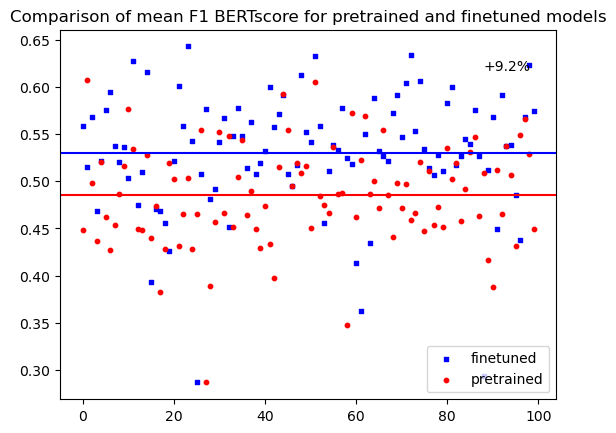

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = range(100)
y1 = finetuned_score['f1']
y2 = pretrained_score['f1']
ft_mean = np.mean(y1)
pt_mean = np.mean(y2)
fig = plt.figure()
ax1 = fig.add_subplot(111)

improvement = np.round(((ft_mean-pt_mean)/pt_mean)*100,1)

ax1.scatter(x, y1, s=10, c='b', marker="s", label='finetuned')
ax1.scatter(x,y2, s=10, c='r', marker="o", label='pretrained')
ax1.axhline(ft_mean,c='b')
ax1.axhline(pt_mean,c='r')
txt = '+' + str(improvement) +'%'
ax1.text(0.9, 0.9, txt, horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
ax1.title.set_text('Comparison of mean F1 BERTscore for pretrained and finetuned models')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sentence_transformers import SentenceTransformer

sentence_embedding_model = SentenceTransformer('sentence-transformers/sentence-t5-base')

# 1 candidate correspond to only 1 reference
def sentence_similarity(references, candidates):
    references_embedding = sentence_embedding_model.encode(references)
    candidates_embedding = sentence_embedding_model.encode(candidates)
    cosine_similarity = []
    for i in range(len(references_embedding)):
        cosine_similarity.append(references_embedding[i].dot(candidates_embedding[i])) # Model normalizes output embedding vector

    return cosine_similarity

ft_similarity = sentence_similarity(test_answers, finetuned_answers)
pt_similarity = sentence_similarity(test_answers, pretrained_answers)

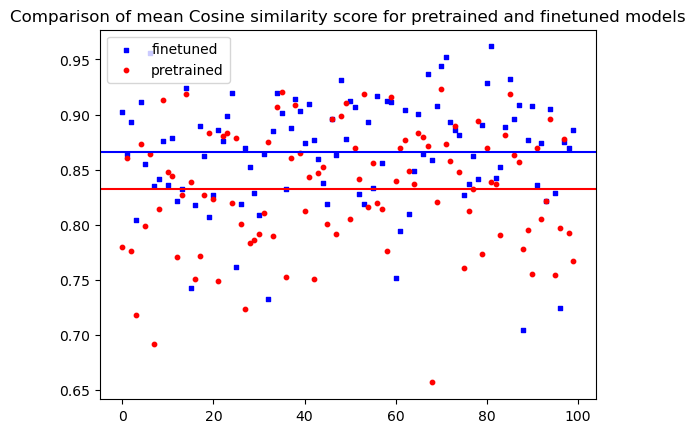

In [ ]:
x = range(100)
y1 = ft_similarity
y2 = pt_similarity
ft_mean = np.mean(y1)
pt_mean = np.mean(y2)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, y1, s=10, c='b', marker="s", label='finetuned')
ax1.scatter(x,y2, s=10, c='r', marker="o", label='pretrained')
ax1.axhline(ft_mean,c='b')
ax1.axhline(pt_mean,c='r')
ax1.title.set_text('Comparison of mean Cosine similarity score for pretrained and finetuned models')
plt.legend(loc='upper left')
plt.show()

### Compare the performance on unseen medical questions (Human evaluation)

In [ ]:
random.seed(2)

# Generate 10 random numbers between 1 and 100
random_numbers = [random.randint(1, df.shape[0]) for _ in range(10)]

df_test = df.iloc[random_numbers,]

df_test = df_test.reset_index(drop=True)

test_questions = df_test['input']
test_answers = df_test['output']

finetuned_new_answers = []
pretrained_new_answers= []

for question in test_questions:
    input_ids = tokenizer.encode(question,  return_tensors="pt") # Tokenizing the question
    set_seed(37)
    ft_ans_tkn = ft_model.generate(input_ids,pad_token_id=tokenizer.pad_token_id, do_sample=True,max_length=50) # Generate the answer with the finetuned model
    pt_ans_tkn = pt_model.generate(input_ids,pad_token_id=tokenizer.pad_token_id, do_sample=True,max_length=50)
    ft_answer = tokenizer.decode(ft_ans_tkn[0]) # Decoding the answer
    pt_answer = tokenizer.decode(pt_ans_tkn[0])
    finetuned_new_answers.append(ft_answer.split('?')[1])
    pretrained_new_answers.append(pt_answer.split('?')[1])

for i in range(5):
    print(str(i+1) + ') ' +test_questions[i])
    print('Finetuned answer: '+ finetuned_new_answers[i])
    print('Pretrained answer: '+ pretrained_new_answers[i]+ '\n')

[3707, 6003, 5563, 23663, 11082, 20195, 16488, 13908, 2342, 10380]
0    What is extra-vascular hemolysis, and how does...
1    In cases of ischemia, which zone of the liver ...
2    In an intense cellular immune response, such a...
3    What are the medical conditions that can be as...
4    What could be the possible diagnosis for a wel...
5    What is the association between Pompe disease ...
6    Which animal is commonly associated with being...
7    Which bacteria is the leading cause of bloodst...
8    What is the role of sulfatides, which are surf...
9    Which type of leukemia is the most common in a...
Name: input, dtype: object
1) What is extra-vascular hemolysis, and how does it lead to the destruction of red blood cells (RBCs)?
Finetuned answer:  Extra-vascular hemolysis is a condition in which blood vessels are able to break down peroxynit
Pretrained answer: 

The most important question for RBC patients is how to prevent this type of transfusion and prevent them from

2) In

### QLoRa Fine-tuning of gpt2 with prompts

The goal here is to use quantization and LoRa to reduce computational cost of the fine-tuning of the model. To fine-tune this model, we will construct prompts from a template.

In [ ]:
!pip install -q -U trl transformers git+https://github.com/huggingface/peft.git  --quiet
!pip install bitsandbytes --quiet
!pip install accelerate --quiet
!pip install evaluate --quiet
!pip install -U sentence-transformers --quiet
!pip install bert-score --quiet

In [ ]:
MODEL = 'gpt2'
TRAIN = True
BERT_MODEL = "microsoft/deberta-base"

In [ ]:
df = pd.read_json('medical_meadow_wikidoc_medical_flashcards.json')
df = df[(df['input'] != "") | (df['output'] != "")]
df = df.drop_duplicates(subset=['input', 'output'])

In [ ]:
from sklearn.model_selection import train_test_split

instruction = df['instruction'].iloc[0]
df = df[['input', "output"]]

In [ ]:
import random
random.seed(1)

random_numbers = [random.randint(1, df.shape[0]) for _ in range(200)]
train_df = df.drop(random_numbers, axis=0)
validation_df = df.iloc[random_numbers,]

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained(MODEL)
tokenizer.pad_token = tokenizer.eos_token

#### Data preparation

In [ ]:
# QA -> Construct a prompt with QA from a template -> Tokenize Prompt
class DataHandler():

  def __init__(self, tokenizer, train_on_inputs=False):
    self.tokenizer = tokenizer
    self.model_max_length = 1024
    self.train_on_inputs = train_on_inputs

  def generate_prompt(self, input, output):
    prompt = f'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.' \
      f'\n\n### Instruction : Your are given a question below. {instruction}.\n\n###Input: {input}\n\n###Response: {output}'
    return prompt

  def tokenize(self, prompt, add_eos_token=True, padding=False, return_tensors=None, truncation=True):
    tkn_prompt = self.tokenizer(prompt, return_tensors=return_tensors, padding=padding, max_length=100, truncation=truncation)

    if (
        tkn_prompt["input_ids"][-1] != self.tokenizer.eos_token_id
        and len(tkn_prompt["input_ids"]) < self.model_max_length
        and add_eos_token
    ):
        tkn_prompt["input_ids"].append(self.tokenizer.eos_token_id)
        tkn_prompt["attention_mask"].append(1)

    tkn_prompt["labels"] = tkn_prompt["input_ids"].copy()
    return tkn_prompt

  def generate_and_tokenize(self, dataPoint, add_eos_token=True):
    prompt = self.generate_prompt(dataPoint['input'], dataPoint['output'])
    tkn_prompt = self.tokenize(prompt, add_eos_token=add_eos_token)

    if not self.train_on_inputs:
            user_prompt: str = self.generate_prompt(
                input=dataPoint.get("input", ""), output=''
            )
            tokenized_user_prompt = self.tokenize(user_prompt, add_eos_token=False)
            user_prompt_len = len(tokenized_user_prompt["input_ids"])
            # Mask out the inputs to compute loss only on the tokens belonging to the answer
            tkn_prompt["labels"] = [
                -100 if i < user_prompt_len else label
                for i, label in enumerate(tkn_prompt["labels"])
            ]
    return tkn_prompt

Example of prompt that will be used to fine tune the model :

In [ ]:
data_handler = DataHandler(tokenizer)
example_prompt = data_handler.generate_prompt(df['input'].iloc[0], df['output'].iloc[0])
print(example_prompt)

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction : Your are given a question below. Answer this question truthfully.

###Input: What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?

###Response: Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.


In [ ]:
train_ds = Dataset.from_pandas(train_df, split="train", preserve_index=False)
validation_ds = Dataset.from_pandas(validation_df, split="test", preserve_index=False)
data = DatasetDict({"train": train_ds, "test": validation_ds})

In [ ]:
for key in data.keys():
  data[key] = data[key].map(data_handler.generate_and_tokenize)

#### QLoRa setup

We setup LoRa for the model to fine-tune. All the model weights are freezed. Only new weights are trained, and the amount of weights to train can be reduced by using matrix decomposition.

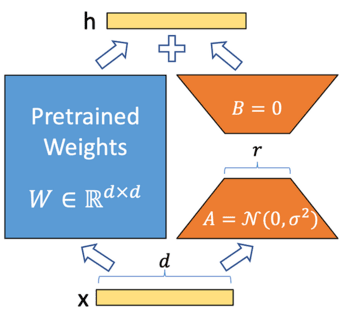

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

In [ ]:
model = GPT2LMHeadModel.from_pretrained(MODEL, quantization_config=quantization_config)
base_model = GPT2LMHeadModel.from_pretrained(MODEL, quantization_config=quantization_config)
prepared_model = prepare_model_for_kbit_training(model)

In [ ]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=None,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

In [ ]:
lora_model = get_peft_model(model, lora_config)
lora_model.to('cuda')
lora_model.print_trainable_parameters()

trainable params: 294,912 || all params: 124,734,720 || trainable%: 0.2364


#### Model training

In [ ]:
args = TrainingArguments(
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    lr_scheduler_type='cosine',
    fp16=True,
    eval_strategy="steps",
    save_steps=200,
    eval_steps=200,
    logging_steps=200,
    load_best_model_at_end=True,
    output_dir="output",
)

In [ ]:
trainer = Trainer(
    model=lora_model,
    args=args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    data_collator=DataCollatorForSeq2Seq(
            tokenizer, pad_to_multiple_of=8, return_tensors='pt', padding=True
        ),
)

In [ ]:
if TRAIN:
    trainer.train()
    lora_model.save_pretrained("ft-gpt-lora")

#### Evaluation

Build the fine-tuned model

In [ ]:
config = PeftConfig.from_pretrained("ft-gpt-lora")
model = GPT2LMHeadModel.from_pretrained(config.base_model_name_or_path)
finetuned_model = PeftModel.from_pretrained(model, "ft-gpt-lora")

Try to generate some answer from test set question :

In [ ]:
def generate_answer(model_to_try, input, generation_config):
    prompt = data_handler.generate_and_tokenize({'input': input, 'output': ''}, add_eos_token=False)
    for key in prompt.keys():
        prompt[key] = torch.tensor(prompt[key]).unsqueeze(0)
    result = model_to_try.generate(**prompt, **generation_config)
    result = result.squeeze()
    result = tokenizer.decode(result)
    return result

In [ ]:
generation_config = {
    'do_sample': True,
    'temperature': 0.8,
    'max_new_tokens': 200
}

##### Test question 1

Fine-tuned answer

In [ ]:
answer = generate_answer(finetuned_model, validation_df['input'].iloc[11], generation_config)
print(f"Question : {validation_df['input'].iloc[11]}\n\nAnswer : \n{answer}\n\nTrue Answer: {validation_df['output'].iloc[11]}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'do_sample': True, 'temperature': 0.8, 'max_new_tokens': 200}
Question : Between primary lung tumors and metastasis to the lung, which is more frequently observed?

Answer : 
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction : Your are given a question below. Answer this question truthfully.

###Input: Between primary lung tumors and metastasis to the lung, which is more frequently observed?

###Response: erythrocyte metastases are more likely to be observed between primary lung tumors and metastasis to the lung.<|endoftext|>

True Answer: Metastasis to the lung is more commonly observed than primary lung tumors. Metastasis is the spread of cancer from one part of the body to another, and it is a common way that lung cancer can spread. Many types of cancer, such as breast, colon, and prostate cancer, can metastasize to the lung. In contrast, primary lung tumors,

Vanilla gpt2 answer

In [ ]:
answer = generate_answer(base_model, validation_df['input'].iloc[11], generation_config)
print(f"Question : {validation_df['input'].iloc[11]}\n\nAnswer : \n{answer}\n\nTrue Answer: {validation_df['output'].iloc[11]}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'do_sample': True, 'temperature': 0.8, 'max_new_tokens': 200}


c:\Users\theom\OneDrive - Université de Technologie de Troyes\Bureau\UTT\SE\NLP\Project\.venv\Lib\site-packages\transformers\generation\utils.py:1632: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


Question : Between primary lung tumors and metastasis to the lung, which is more frequently observed?

Answer : 
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction : Your are given a question below. Answer this question truthfully.

###Input: Between primary lung tumors and metastasis to the lung, which is more frequently observed?

###Response: _____

###Hospitals: You answer this question and the answer is correct.

###Nurses: _____

###Routine Care: The patient is treated with an infusion of chemotherapy to minimize the risk of lung cancer and to prevent further metastasis to the lung.

###Treatment: The patient is given therapy alone. This includes chemotherapy, radiation, and other treatments that may be used to treat metastasis to the lung. The patient is given the chemotherapy treatment at all times.

###Treatment: The patient is given one dose of chemother

##### Test question 2

Fine-tuned answer

In [ ]:
answer = generate_answer(finetuned_model, validation_df['input'].iloc[9], generation_config)
print(f"Question : {validation_df['input'].iloc[9]}\n\nAnswer : \n{answer}\n\nTrue Answer: {validation_df['output'].iloc[9]}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'do_sample': True, 'temperature': 0.8, 'max_new_tokens': 200}
Question : Does guaifenesin inhibit the cough reflex?

Answer : 
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction : Your are given a question below. Answer this question truthfully.

###Input: Does guaifenesin inhibit the cough reflex?

###Response: erythropoietin does not inhibit the cough reflex.<|endoftext|>

True Answer: No, guaifenesin does not inhibit or suppress the cough reflex. Guaifenesin is an expectorant medication that works by thinning and loosening mucus in the airways, making it easier to cough up and clear from the lungs. By helping to clear the airways, guaifenesin can indirectly reduce coughing, but it does not directly affect the cough reflex or suppress it. Guaifenesin is commonly used to treat cough and congestion associated with respiratory infections, allergies, and other cond

Vanilla gpt2 answer

In [ ]:
answer = generate_answer(base_model, validation_df['input'].iloc[9], generation_config)
print(f"Question : {validation_df['input'].iloc[9]}\n\nAnswer : \n{answer}\n\nTrue Answer: {validation_df['output'].iloc[9]}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'do_sample': True, 'temperature': 0.8, 'max_new_tokens': 200}
Question : Does guaifenesin inhibit the cough reflex?

Answer : 
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction : Your are given a question below. Answer this question truthfully.

###Input: Does guaifenesin inhibit the cough reflex?

###Response: ivepense.

###Function: "bio-electrical stimulation of the anterior cingulate cortex (ACC) by a high-voltage motor."

Instructions

I've included a small example video as a part of this article:

https://youtu.be/h1Nr4v2KViE

Notes

If you think that this is useful, I encourage you to do the same!

If you're considering using guaifenesin as a routine on your own, you might want to check out how this can be used in your own practice.

Note that the instruction below does not directly add to a normal cough rhythm. Instead, the stimulus will be a combination

##### Metric computation

In [ ]:
def sentence_similarity(references, candidates):
    references_embedding = sentence_embedding_model.encode(references)
    candidates_embedding = sentence_embedding_model.encode(candidates)
    cosine_similarity = []
    for i in range(len(references_embedding)):
        cosine_similarity.append(np.dot(references_embedding[i], candidates_embedding[i])) # Model normalizes output embedding vector

    return cosine_similarity

In [ ]:
if EVAL:
  from sentence_transformers import SentenceTransformer
  import bert_score
  from evaluate import load
  from tqdm import tqdm

  sentence_embedding_model = SentenceTransformer('sentence-transformers/sentence-t5-base')
  bertscore = load("bertscore")
  base_scores = {'T5': [], 'bert-score': []}
  ft_scores = {'T5': [], 'bert-score': []}

  for example in tqdm(df_test.itertuples()):
      question = example[1]
      answer = example[2]

      ft_gen_answer = generate_answer(finetuned_model, question, generation_config).split('###Response:')[1]
      base_gen_answer = generate_answer(base_model, question, generation_config).split('###Response:')[1]

      ft_bert_score = bertscore.compute(predictions=[ft_gen_answer], references=[answer], model_type=BERT_MODEL)
      base_bert_score = bertscore.compute(predictions=[base_gen_answer], references=[answer], model_type=BERT_MODEL)
      ft_T5_score = sentence_similarity([answer], [ft_gen_answer])
      base_T5_score = sentence_similarity([answer], [base_gen_answer])

      ft_scores['bert-score'].append(ft_bert_score['f1'][0])
      base_scores['bert-score'].append(base_bert_score['f1'][0])
      ft_scores['T5'].append(ft_T5_score[0])
      base_scores['T5'].append(base_T5_score[0])

In [ ]:
import statistics as stat
for key in base_scores.keys():
    print(f'Base average {key}: {round(stat.mean(base_scores[key]), 2)}, FT average {key}: {round(stat.mean(ft_scores[key]), 2)}')

Base average T5: 0.8100000023841858, FT average T5: 0.8700000047683716
Base average bert-score: 0.6, FT average bert-score: 0.69


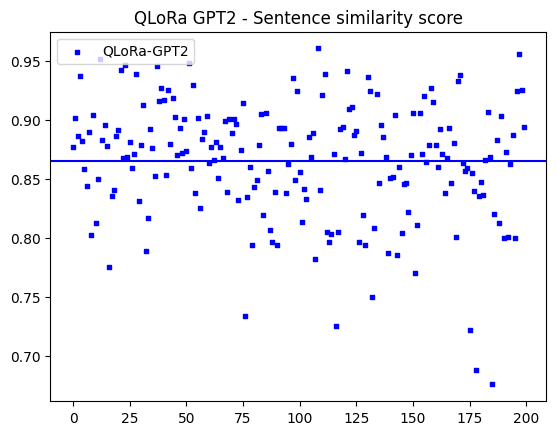

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = range(200)
y1 = ft_scores['T5']
ft_mean = np.mean(y1)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, y1, s=10, c='b', marker="s", label='QLoRa-GPT2')
ax1.axhline(ft_mean,c='b')
ax1.title.set_text('QLoRa GPT2 - Sentence similarity score')
plt.legend(loc='upper left')
plt.show()

Human evaluation :
The model answers were evaluated on a scale from A to D (best to worst) by us on 40 questions. The goal was to evaluate the generated response comparing it to the true answer by human judgment.


The base model never understands the format of the prompt, and sometimes gives an answer that has nothing to do with medical knowledge. It often gives coherent answers, but rarely true.

A: 0 B: 9 C: 17 D:14

The fine-tuned model always understands the prompt, and the answer is frequently coherent, but rarely true. It also has learned the EOS token, and stops generating by itself. No incoherent responses were observed.

A: 0 B: 27 C: 13 D:0

The fine-tune model is thus slightly better in the sense that it is almost always coherent, and that it understands better the format in which to bring the answer. However, the same words keep being generated as the first word of answers, and makes them kind of weird each time.

#### Possible improvments

To improve veracity of responses of the model, we could use a database of medical knowledge. We search the most pertinent document according to the user question, and give this document (the "context") to the model in the template prompt (Instruction + Context + Question + Answer), so that it learns to build a response based on true facts.

Regarding the problem of early generation stopping, we could find a dataset with a more normalized answer length distribution. As there is no correlation bewteen question length and answer length, the current model has no hint where it should stop generating.
With the above approach, the problem could be removed if the length of the true answer is correlated to the length of the related part of the context.

# Phi-3-mini-4k-instruct

## Import dataset

In [ ]:
import pandas as pd

df = pd.read_json('medical_meadow_wikidoc_medical_flashcards.json')

df

,instruction,input,output
0,Answer this question truthfully,What is the relationship between very low Mg2+...,Very low Mg2+ levels correspond to low PTH lev...
1,Answer this question truthfully,What leads to genitourinary syndrome of menopa...,Low estradiol production leads to genitourinar...
2,Answer this question truthfully,What does low REM sleep latency and experienci...,Low REM sleep latency and experiencing halluci...
3,Answer this question truthfully,What are some possible causes of low PTH and h...,"PTH-independent hypercalcemia, which can be ca..."
4,Answer this question truthfully,How does the level of anti-müllerian hormone r...,The level of anti-müllerian hormone is directl...
...,...,...,...
33950,Answer this question truthfully,At what age does bed wetting (enuresis) become...,"At the age of 5 or older, bed wetting (enuresi..."
33951,Answer this question truthfully,,
33952,Answer this question truthfully,,
33953,Answer this question truthfully,,


### Clean empty rows

In [ ]:
df.replace('', pd.NA, inplace = True)
df.dropna(inplace = True)
df.reset_index(drop=True, inplace=True)

df.shape

(33547, 3)

### Split between train and test
100 random rows are taken away to be part of the test set

In [ ]:
import random
random.seed(2)

# Generate n_test random numbers between 1 and 100
n_test = 100
random_numbers = [random.randint(1, df.shape[0]) for _ in range(n_test)]
print(random_numbers)

[3707, 6003, 5563, 23663, 11082, 20195, 16488, 13908, 2342, 10380, 28225, 25791, 33363, 24384, 29154, 32904, 17580, 2355, 1799, 23857, 30468, 20871, 24905, 27762, 10780, 11629, 15475, 15113, 1564, 11582, 21309, 11377, 8959, 33435, 33439, 23573, 11918, 29206, 27176, 23872, 23186, 23717, 29214, 10564, 26206, 30239, 16378, 32114, 18292, 32642, 32824, 23195, 29799, 30213, 22989, 29921, 31891, 14537, 21278, 10884, 17573, 31442, 20288, 19877, 33047, 33251, 26652, 20438, 13620, 32041, 24026, 4940, 22378, 552, 12544, 6958, 3851, 3206, 17898, 14852, 6965, 8946, 17423, 16046, 13794, 3958, 27717, 2089, 3723, 23748, 23608, 11265, 16352, 1537, 5434, 7552, 4422, 1661, 2679, 1386]


In [ ]:
df_train = df.drop(random_numbers, axis=0)
df_test = df.iloc[random_numbers,]

## Import Phi-3-mini-4k-instruct

In [ ]:
!pip install -q -U transformers bitsandbytes accelerate xformers

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.14 requires torch<2.3,>=1.10, but you have torch 2.3.0 which is incompatible.


In [ ]:
!pip install -q -U langchain

In [ ]:
!pip install -q langchain-community langchain-core

In [ ]:
import torch
from transformers import BitsAndBytesConfig
from langchain import HuggingFacePipeline
from langchain import PromptTemplate, LLMChain
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

2024-05-26 11:26:16.944332: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 11:26:16.944428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 11:26:17.065573: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
torch.random.manual_seed(0)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

In [ ]:
generation_args = {
    "max_new_tokens": 200,
    "return_full_text": False,
    "temperature": 0.3,
    "do_sample": True,
}

## Make predictions

In [ ]:
def chatbot(user_request):
  system_prompt = "You are a friendly chatbot."
  messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": user_request},
  ]
  output = pipe(messages, **generation_args)
  return output[0]['generated_text']

In [ ]:
chatbot_outputs = []

for i in range(df_test.shape[0]):
    question = df_test.iloc[i]['input']

    chatbot_outputs.append( chatbot("Answer this question truthfully: '" + question) )

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


## Evaluation

### Cosine Similarity

In [ ]:
!pip install -q sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
from sentence_transformers import SentenceTransformer

sentence_embedding_model = SentenceTransformer('sentence-transformers/sentence-t5-base')

# 1 candidate correspond to only 1 reference
def sentence_similarity(references, candidates):
    references_embedding = sentence_embedding_model.encode(references)
    candidates_embedding = sentence_embedding_model.encode(candidates)
    cosine_similarity = []
    for i in range(len(references_embedding)):
        cosine_similarity.append(references_embedding[i].dot(candidates_embedding[i])) # Model normalizes output embedding vector

    return cosine_similarity

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/219M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

rust_model.ot:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [ ]:
ft_similarity = sentence_similarity(list(df_test['output']), chatbot_outputs)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

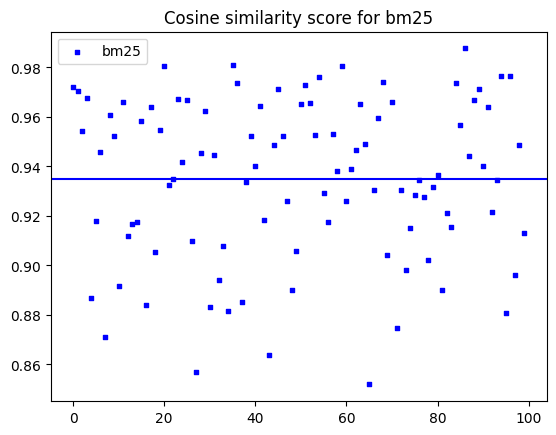

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = range(n_test)
y1 = ft_similarity
ft_mean = np.mean(y1)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, y1, s=10, c='b', marker="s", label='bm25')
ax1.axhline(ft_mean,c='b')
ax1.title.set_text('Cosine similarity score for bm25')
plt.legend(loc='upper left')
plt.show()

In [ ]:
ft_mean = np.mean(ft_similarity)
print(f'The Cosine similarity score for Phi-3 is: {ft_mean}')

The Cosine similarity score for Phi-3 is: 0.9350727796554565


### Bert Score

In [ ]:
references = list(df_test['output'])
qa_answers = chatbot_outputs

In [ ]:
pip install -q bert_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install -q evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import bert_score
from evaluate import load
from transformers import AutoTokenizer
from transformers import AutoModel

In [ ]:
BERT_MODEL = "microsoft/deberta-large-mnli"

In [ ]:
deberta_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
deberta_model = AutoModel.from_pretrained(BERT_MODEL)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

In [ ]:
bertscore = load("bertscore")

bertscore_test = bertscore.compute(predictions=qa_answers, references=references, model_type=BERT_MODEL)
print(bertscore_test['f1'])

[0.612180769443512, 0.6018350720405579, 0.8173840045928955, 0.6246246695518494, 0.6214160919189453, 0.46936941146850586, 1.0000001192092896, 0.904245138168335, 0.6636162400245667, 0.6018439531326294, 0.6575567126274109, 0.5762099623680115, 0.8727757334709167, 0.8130170702934265, 0.7179307341575623, 0.6468074321746826, 0.6878206133842468, 0.6459906101226807, 0.7513480186462402, 0.6389890909194946, 0.6267948746681213, 0.8739498853683472, 0.7094058990478516, 0.6079435348510742, 0.510646402835846, 0.5916491150856018, 0.6850693821907043, 0.6933337450027466, 0.7527691125869751, 0.640296459197998, 0.7518450617790222, 0.6164710521697998, 0.6529725790023804, 0.6783169507980347, 0.7842605113983154, 0.5924064517021179, 0.6756036877632141, 0.768284261226654, 0.9633479118347168, 0.6289734840393066, 0.6507468819618225, 0.6415592432022095, 0.8306564688682556, 0.6146062016487122, 0.5844846367835999, 0.6056815981864929, 0.5850613713264465, 0.81064772605896, 0.8912556767463684, 0.8545228838920593, 0.590

In [ ]:
import statistics
mean_bertscore_sentence_transformers=statistics.mean(bertscore_test['f1'])
print(f'The Bert score for Phi-3 is: {mean_bertscore_sentence_transformers}')

The Bert score for Phi-3 is: 0.6336174091696739


# Summary table

In [ ]:
import pandas as pd

In [ ]:
# Example data
models = ["bm25", "ST-Retrieval", "GPT-2", "Qlora_GPT-2", "Phi-3"]
cosine_scores = [0.783, 0.79, 0.81, 0.87, 0.935]
bert_scores = [0.499, 0.50, 0.53, 0.69, 0.634]

# Combine scores into a DataFrame
data = {
    'Models': models,
    'Cosine_Score': cosine_scores,
    'BERT_Score': bert_scores,
}

df_scores = pd.DataFrame(data)

print(df_scores)

         Models  Cosine_Score  BERT_Score
0          bm25         0.783       0.499
1  ST-Retrieval         0.790       0.500
2         GPT-2         0.810       0.530
3   Qlora_GPT-2         0.870       0.690
4         Phi-3         0.935       0.634


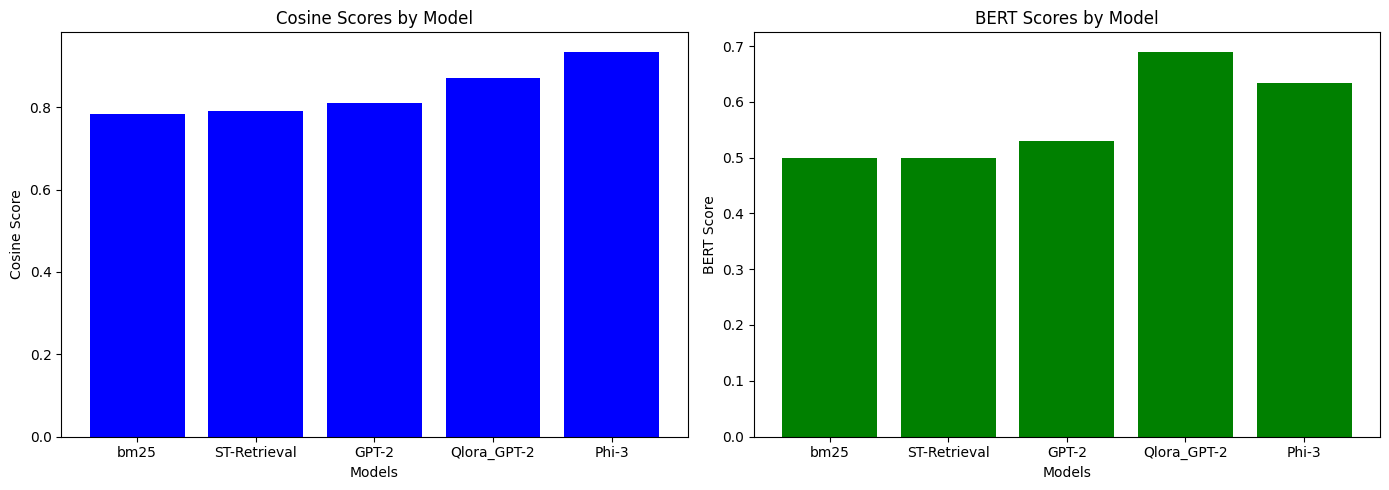

In [ ]:
import matplotlib.pyplot as plt

# Plotting the scores
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot for Cosine scores
ax[0].bar(df_scores['Models'], df_scores['Cosine_Score'], color='blue')
ax[0].set_title('Cosine Scores by Model')
ax[0].set_xlabel('Models')
ax[0].set_ylabel('Cosine Score')

# Bar plot for BERT scores
ax[1].bar(df_scores['Models'], df_scores['BERT_Score'], color='green')
ax[1].set_title('BERT Scores by Model')
ax[1].set_xlabel('Models')
ax[1].set_ylabel('BERT Score')

plt.tight_layout()
plt.show()

# Comparaison of the outputs of the models

In [ ]:
# First 10 questions of the test set
list(df_test.iloc[:10]['input'])

['What is extra-vascular hemolysis, and how does it lead to the destruction of red blood cells (RBCs)?',
 'In cases of liver damage from ingested toxins such as cocaine, which zone of the liver is typically affected first?',
 'In cases of blunt trauma to the bladder, which specific region of the bladder may result in chemical peritonitis if ruptured?',
 'Can Rifampin/Rifabutin be used to treat both tuberculous and nontuberculous mycobacteria?',
 'What could be the possible diagnosis for a three-month-old that presents with severe hypoglycemia and lactic acidosis, with a doll-like face and hepatomegaly?',
 'What are the risk factors associated with polyhydramnios and multiple gestation during pregnancy?',
 'What is the remnant of the umbilical arteries called?',
 'Among community-acquired cases of bacterial meningitis, which bacteria is the most frequent cause?',
 'What is the role of sulfatides, which are surface glycolipids of Mycobacterium tuberculosis, in the inhibition of phagolyso

In [ ]:
# First 10 answers of the test set
list(df_test.iloc[:10]['output'])

['Extra-vascular hemolysis is a process by which red blood cells (RBCs) are destroyed outside of the blood vessels, typically by the reticuloendothelial system (RES), which includes the spleen and liver. In this process, RBCs are removed from circulation and taken up by the RES, where they are broken down and their components are recycled. Extra-vascular hemolysis can occur as a result of a variety of conditions, including autoimmune disorders, infections, and certain medications. When RBCs are destroyed at a faster rate than they can be replaced, this can lead to anemia, which is characterized by a low level of hemoglobin in the blood and a decreased ability of the blood to carry oxygen. Treatment for extra-vascular hemolysis typically involves addressing the underlying cause of the condition, as well as providing supportive care to manage symptoms and prevent complications.',
 "The periportal zone, also known as Zone I, is typically the first liver zone to be affected by ingested tox

In [ ]:
# First 10 outputs of the retreival based chatbot
bm25_outputs

['Interstitial (atypical) pneumonia is a type of pneumonia that is characterized by diffuse interstitial infiltrates. This means that the inflammation and fluid build-up associated with the infection are spread out throughout the lung tissue, rather than being concentrated in a specific area. Interstitial pneumonia can be caused by a variety of pathogens, including bacteria, viruses, and fungi, but it is most commonly associated with atypical pathogens, such as Mycoplasma pneumoniae, Chlamydophila pneumoniae, and Legionella pneumophila. The symptoms of interstitial pneumonia can include cough, fever, fatigue, and shortness of breath, but they are often milder than those of typical pneumonia. Diagnosis of interstitial pneumonia typically involves a combination of clinical evaluation, imaging studies, and laboratory tests, and treatment may involve antibiotics and supportive care to manage symptoms.',
 'Apoproteins C and E are stored in HDL (high-density lipoprotein). HDL is a lipoprotei

In [ ]:
qlora-gpt2_output

[' erythrocyte conversion is a type of thrombocytopenia that can lead to the destruction<|endoftext|>',
 ' erythropoietin is the dominant oil in human liver. The drug is also often used<|endoftext|>',
 ' erythrocytes, cytoplosporin, and<|endoftext|>',
 ' erythrocyte conjugation should be used to treat both tuberculous and nontuberculous mycobacteria.<|endoftext|>',
 ' erythema could be a diagn<|endoftext|>',
 ' erythema migrans is a risk factor for polyhydramnios and multiple gestation during pregnancy.<|endoftext|>',
 ' ipsilateral arterial arteries (PEACs) are the remnant of umbilical arteries called, depending on their location on the pelvis or the tr<|endoftext|>',
 ' ichneumonicis, which bacteria is the most common cause of bacterial meningitis among community-acquired cases of bacterial meningitis who exhibit the<|endoftext|>',
 ' erythropoietin is a biotin that<|endoftext|>',
 ' erythema migrans is most frequently the most common cause of intussusception in adults. The main symp

In [ ]:
Phi3_outputs[:10]

[' Extravascular hemolysis refers to the destruction of red blood cells (RBCs) outside the blood vessels, primarily in the spleen, liver, and bone marrow. This process occurs when RBCs are recognized as abnormal or aged by the reticuloendothelial system (RES), which is composed of phagocytic cells such as macrophages.\n\nThe destruction of RBCs in extravascular hemolysis is mainly due to the recognition of RBCs with damaged or altered membranes by the RES. This can be caused by various factors, including hereditary conditions, infections, or immune-mediated processes.\n\nWhen RBCs are recognized as abnormal, they are engulfed and broken down by the RES cells. The hemoglobin released from the destroyed RBCs is then metabolized into heme and globin. H',
 " In cases of liver damage from ingested toxins such as cocaine, the zone of the liver that is typically affected first is the periportal zone, also known as Zone 1. This zone is closest to the portal triad, which includes the portal vei